In [2]:
"""
Do Woo et al 2016 analysis: moments etc.

Author: Alan Nguyen

24-06-2020
"""

'\nDo Woo et al 2016 analysis: moments etc.\n\nAuthor: Alan Nguyen\n\n24-06-2020\n'

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table, Column
from scipy.optimize import curve_fit, leastsq
from scipy.stats import spearmanr
from astropy.cosmology import WMAP9 as cosmo
from astropy import units as u
import os
import math as m
from astropy import constants as const
import time
from BOSS_func_v9 import *
from general_functions_v1 import *
import matplotlib.patches as mpatches

In [4]:
hdul = fits.open('AGN_results_files\zbin1_results_v2.fits')

zbin1_results = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_results_files\zbin2_results_v2.fits')

zbin2_results = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_results_files\zbin3_results_v2.fits')

zbin3_results = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_results_files\zbin4_results_v2.fits')

zbin4_results = hdul[1].data

hdul.close()

In [5]:
zbin1_dict = {}

for row in zbin1_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin1_dict.update({key:[parameters, scale, parameters_err, flag]})

In [6]:
zbin2_dict = {}

for row in zbin2_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin2_dict.update({key:[parameters, scale, parameters_err, flag]})

In [7]:
zbin3_dict = {}

for row in zbin3_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin3_dict.update({key:[parameters, scale, parameters_err, flag]})

In [8]:
zbin4_dict = {}

for row in zbin4_results:
    key = row['KEY']
    parameters = np.array([row['CORE_AMP'], row['CORE_VEL'], row['CORE_VELDIS'], 
                           row['WING_AMP'], row['WING_VEL'], row['WING_VELDIS']])
    
    parameters_err = np.array([row['CORE_AMP_ERR'], row['CORE_VEL_ERR'], row['CORE_VELDIS_ERR'], 
                               row['WING_AMP_ERR'], row['WING_VEL_ERR'], row['WING_VELDIS_ERR']])
    
    flag = row['FLAG'] 
    scale = row['FLUXDEN_SCALE']
    zbin4_dict.update({key:[parameters, scale, parameters_err, flag]})

In [9]:
def double_gaussian( x, params ):
    (amp1, vel1, vel_sigma1, amp2, vel2, vel_sigma2) = params
    return gaussian(x, [amp1, vel1, vel_sigma1]) + gaussian(x,  [amp2, vel2, vel_sigma2])

In [10]:
hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin1_v2.fits')

zbin1_data = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin2_v2.fits')

zbin2_data = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin3_v2.fits')

zbin3_data = hdul[1].data

hdul.close()

##################################################################################

hdul = fits.open('AGN_zbin_fitsfiles\AGN_zbin4_v2.fits')

zbin4_data = hdul[1].data

hdul.close()


In [11]:
##################################################################################
################################################################################## LOOKING FOR AVERAGE CONTINUUM SN
##################################################################################
##################################################################################

In [12]:
specs_zbin1 ={}
count = 0

for row in zbin1_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin1_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin1.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin1_data)), end = "") #progress bar to keep track of progress

Complete: 24/820

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 820/820

In [13]:
specs_zbin2 ={}
count = 0

for row in zbin2_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin2_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin2.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin2_data)), end = "") #progress bar to keep track of progress

Complete: 19/1282

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 1282/1282

In [14]:
specs_zbin3 ={}
count = 0

for row in zbin3_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin3_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin3.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin3_data)), end = "") #progress bar to keep track of progress

Complete: 13/1659

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 1659/1659

In [15]:
specs_zbin4 ={}
count = 0

for row in zbin4_data:
    
    ######################################### set up file directories
    
    PLATE = str(row['PLATE'])
    MJD   = str(row['MJD'])
    FIBER = '{:04}'.format(row['FIBERID'])
    key_list = ['spec',PLATE, MJD, FIBER]
    key = '-'.join(key_list)
    filename = key + '.fits'
    folder = 'zbin4_specs'
    
    directory = os.path.join(folder, PLATE, filename)

    #########################################
    
    z = row['Z']
    k = 1 + z
    
    #########################################
    
    hdul = fits.open(directory) #using above directory open fits for the specific spectra
    data = hdul[1].data #again take only data not the header
    wave = 10 ** data['loglam'] #convert wavelength back to linear scale
    fluxden = data['flux'] #take fluxden
    inverse_variance = data['ivar'] #take inverse variance
    error = np.sqrt( 1 / inverse_variance ) #convert to standard deviation
    hdul.close()
    
    #########################################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(wave)    #0 
    tempdat.append(fluxden) #1
    tempdat.append(k)       #2
    tempdat.append(error)   #3
    
    specs_zbin4.update({key:tempdat})
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(zbin4_data)), end = "") #progress bar to keep track of progress

Complete: 15/1258

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


Complete: 1258/1258

In [16]:
##############################################################
############################################################## DO SN CONT
##############################################################

In [25]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

count = 0 #for a loading bar lmao

zbin1_noise = []

zbin1_HA_peak = []
zbin1_OIII_peak = []

for key in specs_zbin1: #for every spectrum generated in previous block
    wave = specs_zbin1[key][0] #extract wavelength array
    fluxden = specs_zbin1[key][1] #extract flux density array
    k = specs_zbin1[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin1[key][3] #extract flux density error array
    
    ###############################
    ###############################
    
    HA_select = (wave > 6553*k) & (wave < 6573*k)
    
    OIII_select = (wave > 4980*k) & (wave < 5030*k)
    
    HA_peak_temp   = np.max(fluxden[HA_select])
    OIII_peak_temp = np.max(fluxden[OIII_select])
    
    cont_select = (wave > 5030*k) & (wave < 5130*k) #create parameter to trim the data for the [OIII]5007 line

    cont_fluxden = fluxden[cont_select] #select for [OIII]5007
    
    noise = np.std(np.array(cont_fluxden))
    
    zbin1_noise.append(noise)
    zbin1_HA_peak.append(HA_peak_temp)
    zbin1_OIII_peak.append(OIII_peak_temp)
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin1)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
zbin1_HA_peak     = np.array(zbin1_HA_peak)
zbin1_OIII_peak   = np.array(zbin1_OIII_peak)
zbin1_noise = np.array(zbin1_noise)

zbin1_HA_AN = zbin1_HA_peak / zbin1_noise
zbin1_OIII_AN = zbin1_OIII_peak / zbin1_noise
    
# for s in bad_specs: #remove bad spectra from the trimmed dictionary
#     trimmed_specs_zbin1.pop(key, None)

Complete: 820/820

In [26]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

count = 0 #for a loading bar lmao

zbin2_noise = []

zbin2_HA_peak = []
zbin2_OIII_peak = []

for key in specs_zbin2: #for every spectrum generated in previous block
    wave = specs_zbin2[key][0] #extract wavelength array
    fluxden = specs_zbin2[key][1] #extract flux density array
    k = specs_zbin2[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin2[key][3] #extract flux density error array
    
    ###############################
    ###############################
    
    HA_select = (wave > 6553*k) & (wave < 6573*k)
    
    OIII_select = (wave > 4980*k) & (wave < 5030*k)
    
    HA_peak_temp   = np.max(fluxden[HA_select])
    OIII_peak_temp = np.max(fluxden[OIII_select])
    
    cont_select = (wave > 5030*k) & (wave < 5130*k) #create parameter to trim the data for the [OIII]5007 line

    cont_fluxden = fluxden[cont_select] #select for [OIII]5007
    
    noise = np.std(np.array(cont_fluxden))
    
    zbin2_noise.append(noise)
    zbin2_HA_peak.append(HA_peak_temp)
    zbin2_OIII_peak.append(OIII_peak_temp)
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin2)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
zbin2_HA_peak     = np.array(zbin2_HA_peak)
zbin2_OIII_peak   = np.array(zbin2_OIII_peak)
zbin2_noise = np.array(zbin2_noise)

zbin2_HA_AN = zbin2_HA_peak / zbin2_noise
zbin2_OIII_AN = zbin2_OIII_peak / zbin2_noise
    
# for s in bad_specs: #remove bad spectra from the trimmed dictionary
#     trimmed_specs_zbin1.pop(key, None)

Complete: 1282/1282

In [27]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

count = 0 #for a loading bar lmao

zbin3_noise = []

zbin3_HA_peak = []
zbin3_OIII_peak = []

for key in specs_zbin3: #for every spectrum generated in previous block
    wave = specs_zbin3[key][0] #extract wavelength array
    fluxden = specs_zbin3[key][1] #extract flux density array
    k = specs_zbin3[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin3[key][3] #extract flux density error array
    
    ###############################
    ###############################
    
    HA_select = (wave > 6553*k) & (wave < 6573*k)
    
    OIII_select = (wave > 4980*k) & (wave < 5030*k)
    
    HA_peak_temp   = np.max(fluxden[HA_select])
    OIII_peak_temp = np.max(fluxden[OIII_select])
    
    cont_select = (wave > 5030*k) & (wave < 5130*k) #create parameter to trim the data for the [OIII]5007 line

    cont_fluxden = fluxden[cont_select] #select for [OIII]5007
    
    noise = np.std(np.array(cont_fluxden))
    
    zbin3_noise.append(noise)
    zbin3_HA_peak.append(HA_peak_temp)
    zbin3_OIII_peak.append(OIII_peak_temp)
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin3)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
zbin3_HA_peak     = np.array(zbin3_HA_peak)
zbin3_OIII_peak   = np.array(zbin3_OIII_peak)
zbin3_noise = np.array(zbin3_noise)

zbin3_HA_AN = zbin3_HA_peak / zbin3_noise
zbin3_OIII_AN = zbin3_OIII_peak / zbin3_noise
    
# for s in bad_specs: #remove bad spectra from the trimmed dictionary
#     trimmed_specs_zbin1.pop(key, None)

Complete: 1659/1659

In [28]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

count = 0 #for a loading bar lmao

zbin4_noise = []

zbin4_HA_peak = []
zbin4_OIII_peak = []

for key in specs_zbin4: #for every spectrum generated in previous block
    wave = specs_zbin4[key][0] #extract wavelength array
    fluxden = specs_zbin4[key][1] #extract flux density array
    k = specs_zbin4[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin4[key][3] #extract flux density error array
    
    ###############################
    ###############################
    
    HA_select = (wave > 6553*k) & (wave < 6573*k)
    
    OIII_select = (wave > 4980*k) & (wave < 5030*k)
    
    HA_peak_temp   = np.max(fluxden[HA_select])
    OIII_peak_temp = np.max(fluxden[OIII_select])
    
    cont_select = (wave > 5030*k) & (wave < 5130*k) #create parameter to trim the data for the [OIII]5007 line

    cont_fluxden = fluxden[cont_select] #select for [OIII]5007
    
    noise = np.std(np.array(cont_fluxden))
    
    zbin4_noise.append(noise)
    zbin4_HA_peak.append(HA_peak_temp)
    zbin4_OIII_peak.append(OIII_peak_temp)
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin4)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
zbin4_HA_peak     = np.array(zbin4_HA_peak)
zbin4_OIII_peak   = np.array(zbin4_OIII_peak)
zbin4_noise = np.array(zbin4_noise)

zbin4_HA_AN = zbin4_HA_peak / zbin4_noise
zbin4_OIII_AN = zbin4_OIII_peak / zbin4_noise
    
# for s in bad_specs: #remove bad spectra from the trimmed dictionary
#     trimmed_specs_zbin1.pop(key, None)

Complete: 1258/1258

In [29]:
select_zbin1_AN = (zbin1_HA_AN > 5) & (zbin1_OIII_AN > 5)
select_zbin2_AN = (zbin2_HA_AN > 5) & (zbin2_OIII_AN > 5)
select_zbin3_AN = (zbin3_HA_AN > 5) & (zbin3_OIII_AN > 5)
select_zbin4_AN = (zbin4_HA_AN > 5) & (zbin4_OIII_AN > 5)

In [24]:
##############################################################
############################################################## END SN CONT
##############################################################

In [25]:
##############################################################
############################################################## START CALCULATE MOMENTS
##############################################################

In [35]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin1 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin1: #for every spectrum generated in previous block
    wave = specs_zbin1[key][0] #extract wavelength array
    fluxden = specs_zbin1[key][1] #extract flux density array
    k = specs_zbin1[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin1[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin1.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin1)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin1.pop(key, None)

Complete: 820/820

In [36]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin2 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin2: #for every spectrum generated in previous block
    wave = specs_zbin2[key][0] #extract wavelength array
    fluxden = specs_zbin2[key][1] #extract flux density array
    k = specs_zbin2[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin2[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin2.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin2)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin2.pop(key, None)

Complete: 1282/1282

In [37]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin3 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin3: #for every spectrum generated in previous block
    wave = specs_zbin3[key][0] #extract wavelength array
    fluxden = specs_zbin3[key][1] #extract flux density array
    k = specs_zbin3[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin3[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin3.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin3)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin3.pop(key, None)

Complete: 468/1659

Complete: 920/1659

Complete: 1337/1659

Complete: 1659/1659

In [38]:
#
#bring down the size of the dictionary to create a smaller working dictionary, trimmed just for the [OIII]5007 line
#

trimmed_specs_zbin4 = {}

count = 0 #for a loading bar lmao

bad_specs = []

for key in specs_zbin4: #for every spectrum generated in previous block
    wave = specs_zbin4[key][0] #extract wavelength array
    fluxden = specs_zbin4[key][1] #extract flux density array
    k = specs_zbin4[key][2] #z + 1, to account for redshift during the trimming
    error = specs_zbin4[key][3] #extract flux density error array
    
    ###############################
    ###############################

    OIII_select = (wave > 4980*k) & (wave < 5030*k) #create parameter to trim the data for the [OIII]5007 line

    OIII_wave = wave[OIII_select] #select for [OIII]5007
    OIII_fluxden = fluxden[OIII_select] #select for [OIII]5007
    OIII_error = error[OIII_select] #select for [OIII]5007
    
    ###############################
    ###############################
    
    inf_indices = np.where(OIII_error == np.inf) #take indices where error is infinity for some reason?
    
    mean_error = np.mean(OIII_error[OIII_error != np.inf]) #take the mean error from the [OIII]5007 slice
    
    for i in inf_indices[0]: #replace all the infinity indices with the mean error
        OIII_error[i] = mean_error
    
    ###############################
    ###############################
    
    OIII_fluxden_scale = np.max(OIII_fluxden) #take the scale factor as the maximum flux density in this region
    
    OIII_norm_fluxden = OIII_fluxden / OIII_fluxden_scale #normalize so the peak is at one
    OIII_norm_error = OIII_error / OIII_fluxden_scale #scale the error to preserve relationship with flux density
    
    ###############################
    ###############################
    
    tempdat = [] #temporary list to hold each dataset before adding it to the dictionary
    
    #list indices to the right, called with spec-XXXX-XXXXX-XXXX, PLATE-MJD-FIBERID
    tempdat.append(OIII_wave)          #0 wavelength
    tempdat.append(OIII_norm_fluxden)  #1 normalized flux density
    tempdat.append(k)                  #2 k = z + 1
    tempdat.append(OIII_norm_error)    #3 normalized flux density error
    tempdat.append(OIII_fluxden_scale) #4 maximum flux density used to scale normalized flux density
    
    trimmed_specs_zbin4.update({key:tempdat}) #update the trimmed dictionary with a smaller dataset
    
    ###############################
    ###############################
    
    if OIII_fluxden_scale == 0: #add to list of "flat" spectra
        bad_specs.append(key)
    
    ###############################
    ###############################
    
    count += 1
    print("\r" + "Complete: {}/{}".format(count,len(specs_zbin4)), end = "") #progress bar to keep track of progress
    
    ###############################
    ###############################
    
for s in bad_specs: #remove bad spectra from the trimmed dictionary
    trimmed_specs_zbin4.pop(key, None)

Complete: 1258/1258

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in float_scalars
C:\Users\ANguyen\MyWorks\BOSS_func_v9.py:47: RuntimeWarning: divide by zero encountered in true_divide
  return amp * np.exp( - (x - to_angstrom_OIII(vel))**2.0 / (2.0 * (line_width_OIII(vel_sigma))**2.0) )
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\ProgramData\Anaconda3\lib\sit

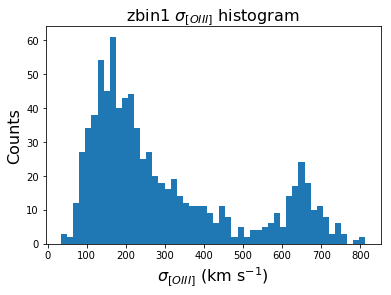

    Original Count:   820
             Count:   814
              Mean:   297.5076946338635
            Median:   223.38214844057802
Standard Deviation:   191.2265428672905
           Minimum:   34.555593908445864
           Maximum:   813.1260366062634


In [39]:
OIII_sigma_list_zbin1 = []
OIII_sigma_err_list_zbin1 = []

for key in zbin1_dict:
    
    temp_sigma_list = []
    
    parameters     = zbin1_dict[key][0]
    fluxden_scale  = zbin1_dict[key][1]
    parameters_err = zbin1_dict[key][2]
    flag           = zbin1_dict[key][3]
    
    wave = trimmed_specs_zbin1[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err)
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )

        temp_sigma_list.append(temp_OIII_sigma)
        
    
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin1.append(OIII_sigma)
    OIII_sigma_err_list_zbin1.append(OIII_sigma_err)

OIII_sigma_array_zbin1 = np.array(OIII_sigma_list_zbin1)
OIII_sigma_err_array_zbin1 = np.array(OIII_sigma_err_list_zbin1)

fractional_error_zbin1 = OIII_sigma_err_array_zbin1 / OIII_sigma_array_zbin1
select_good_zbin1 = ( OIII_sigma_array_zbin1 > 30 ) & ( fractional_error_zbin1 < 1 ) & ~np.isnan(fractional_error_zbin1)
OIII_sigma_array_zbin1_good = OIII_sigma_array_zbin1[select_good_zbin1]

plt.hist(OIII_sigma_array_zbin1_good, bins = 50)

plt.title(r'zbin1 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin1_dict)))
array_summary(OIII_sigma_array_zbin1_good)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in float_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less


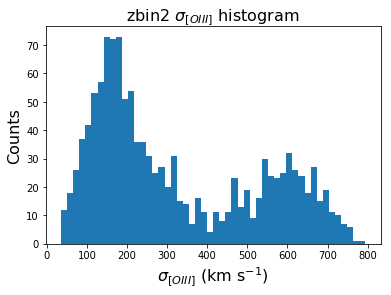

    Original Count:   1282
             Count:   1250
              Mean:   321.4492642638955
            Median:   241.70237090220326
Standard Deviation:   203.8329448260558
           Minimum:   35.45163644806948
           Maximum:   794.4340769463452


In [40]:
OIII_sigma_list_zbin2 = []
OIII_sigma_err_list_zbin2 = []

for key in zbin2_dict:
    
    temp_sigma_list = []
    
    parameters     = zbin2_dict[key][0]
    fluxden_scale  = zbin2_dict[key][1]
    parameters_err = zbin2_dict[key][2]
    flag           = zbin2_dict[key][3]
    
    wave = trimmed_specs_zbin2[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err) 
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )

        temp_sigma_list.append(temp_OIII_sigma)
        
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin2.append(OIII_sigma)
    OIII_sigma_err_list_zbin2.append(OIII_sigma_err)


OIII_sigma_array_zbin2 = np.array(OIII_sigma_list_zbin2)
OIII_sigma_err_array_zbin2 = np.array(OIII_sigma_err_list_zbin2)

fractional_error_zbin2 = OIII_sigma_err_array_zbin2 / OIII_sigma_array_zbin2
select_good_zbin2 = ( OIII_sigma_array_zbin2 > 30 ) & ( fractional_error_zbin2 < 1 ) & ~np.isnan(fractional_error_zbin2)
OIII_sigma_array_zbin2_good = OIII_sigma_array_zbin2[select_good_zbin2]

plt.hist(OIII_sigma_array_zbin2_good, bins = 50)

plt.title(r'zbin2 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin2_dict)))
array_summary(OIII_sigma_array_zbin2_good)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in float_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in double_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less


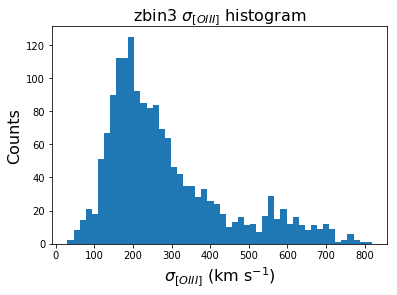

    Original Count:   1659
             Count:   1635
              Mean:   284.27972466529525
            Median:   238.41442655248102
Standard Deviation:   153.9776600867038
           Minimum:   30.151755693304885
           Maximum:   818.5039134950785


In [41]:
OIII_sigma_list_zbin3 = []
OIII_sigma_err_list_zbin3 = []

for key in zbin3_dict:
    
    temp_sigma_list = []
    
    parameters     = zbin3_dict[key][0]
    fluxden_scale  = zbin3_dict[key][1]
    parameters_err = zbin3_dict[key][2]
    flag           = zbin3_dict[key][3]
    
    wave = trimmed_specs_zbin3[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err) 
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )

        temp_sigma_list.append(temp_OIII_sigma)
        
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin3.append(OIII_sigma)
    OIII_sigma_err_list_zbin3.append(OIII_sigma_err)


OIII_sigma_array_zbin3 = np.array(OIII_sigma_list_zbin3)
OIII_sigma_err_array_zbin3 = np.array(OIII_sigma_err_list_zbin3)

fractional_error_zbin3 = OIII_sigma_err_array_zbin3 / OIII_sigma_array_zbin3
select_good_zbin3 = ( OIII_sigma_array_zbin3 > 30 ) & ( fractional_error_zbin3 < 1 ) & ~np.isnan(fractional_error_zbin3)
OIII_sigma_array_zbin3_good = OIII_sigma_array_zbin3[select_good_zbin3]

plt.hist(OIII_sigma_array_zbin3_good, bins = 50)

plt.title(r'zbin3 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin3_dict)))
array_summary(OIII_sigma_array_zbin3_good)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in float_scalars
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in greater
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less


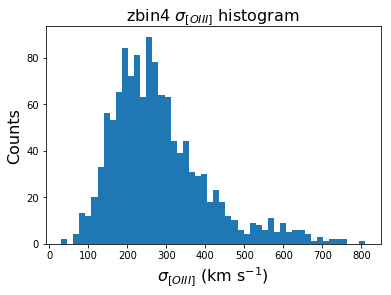

    Original Count:   1258
             Count:   1241
              Mean:   282.4834744511247
            Median:   259.8147496464662
Standard Deviation:   123.58234632270144
           Minimum:   30.390182877479546
           Maximum:   810.1106930844253


In [42]:
OIII_sigma_list_zbin4 = []
OIII_sigma_err_list_zbin4 = []

for key in zbin4_dict:
    
    temp_sigma_list = []
    
    parameters     = zbin4_dict[key][0]
    fluxden_scale  = zbin4_dict[key][1]
    parameters_err = zbin4_dict[key][2]
    flag           = zbin4_dict[key][3]
    
    wave = trimmed_specs_zbin4[key][0]
    
    for trial in range(100):
        iter_params = np.random.normal(parameters, parameters_err) 
        
        while ( iter_params[0] < 0 ) or ( iter_params[1] < 0 ) or ( iter_params[2] < 0 ) or ( iter_params[3] < 0 ) or ( iter_params[4] < 0 ) or ( iter_params[5] < 0 ):
                iter_params = np.random.normal(parameters, parameters_err)
        
        if flag == 1:
            norm_fluxden = gaussian(wave, iter_params[3:6])
        else:
            norm_fluxden = double_gaussian(wave, iter_params)
            
        true_fluxden = fluxden_scale * norm_fluxden

        zero_moment = np.sum( true_fluxden )
        first_moment = np.sum( wave * true_fluxden ) / zero_moment
        second_moment = np.sum( ( ( wave - first_moment ) ** 2 ) * true_fluxden ) / zero_moment

        temp_OIII_sigma = 300000 * ( np.sqrt(second_moment) / first_moment )

        temp_sigma_list.append(temp_OIII_sigma)
    
    clean_temp_sigma_list = [x for x in temp_sigma_list if str(x) != 'nan']
    
    OIII_sigma = np.mean(np.array(clean_temp_sigma_list))
    OIII_sigma_err = np.std(np.array(clean_temp_sigma_list))
    
    OIII_sigma_list_zbin4.append(OIII_sigma)
    OIII_sigma_err_list_zbin4.append(OIII_sigma_err)


OIII_sigma_array_zbin4 = np.array(OIII_sigma_list_zbin4)
OIII_sigma_err_array_zbin4 = np.array(OIII_sigma_err_list_zbin4)

fractional_error_zbin4 = OIII_sigma_err_array_zbin4 / OIII_sigma_array_zbin4
select_good_zbin4 = ( OIII_sigma_array_zbin4 > 30 ) & ( fractional_error_zbin4 < 1 ) & ~np.isnan(fractional_error_zbin4)
OIII_sigma_array_zbin4_good = OIII_sigma_array_zbin4[select_good_zbin4]

plt.hist(OIII_sigma_array_zbin4_good, bins = 50)

plt.title(r'zbin4 $\sigma$$_{[OIII]}$ histogram', fontsize = 16)
plt.ylabel('Counts', fontsize = 16)
plt.xlabel(r'$\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 16)

plt.show()

print('    Original Count:   {}'.format(len(zbin4_dict)))
array_summary(OIII_sigma_array_zbin4_good)

In [34]:
##############################################################
############################################################## END CALCULATE MOMENTS
##############################################################

In [35]:
##############################################################
############################################################## START LUMINOSITY, EDDINGTON RATIOS
##############################################################

In [36]:
zbin1_data_v2 = zbin1_data[select_good_zbin1] # cut data for wing frac error etc.
zbin2_data_v2 = zbin2_data[select_good_zbin2]
zbin3_data_v2 = zbin3_data[select_good_zbin3]
zbin4_data_v2 = zbin4_data[select_good_zbin4]

In [37]:
##################################################################################

zbin1_OIII_flux = zbin1_data_v2['FLUX'][:, 17]
zbin1_redshift  = zbin1_data_v2['Z']

zbin2_OIII_flux = zbin2_data_v2['FLUX'][:, 17]
zbin2_redshift  = zbin2_data_v2['Z']

zbin3_OIII_flux = zbin3_data_v2['FLUX'][:, 17]
zbin3_redshift  = zbin3_data_v2['Z']

zbin4_OIII_flux = zbin4_data_v2['FLUX'][:, 17]
zbin4_redshift  = zbin4_data_v2['Z']

##################################################################################

zbin1_lum_dis = cosmo.luminosity_distance(zbin1_redshift)
zbin1_lum_dis = zbin1_lum_dis.to(u.cm)
zbin1_OIII_flux_correct_units = zbin1_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin1_OIII_lum = 4 * np.pi * zbin1_OIII_flux_correct_units * (zbin1_lum_dis ** 2)

##################################################################################

zbin2_lum_dis = cosmo.luminosity_distance(zbin2_redshift)
zbin2_lum_dis = zbin2_lum_dis.to(u.cm)
zbin2_OIII_flux_correct_units = zbin2_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin2_OIII_lum = 4 * np.pi * zbin2_OIII_flux_correct_units * (zbin2_lum_dis ** 2)

##################################################################################

zbin3_lum_dis = cosmo.luminosity_distance(zbin3_redshift)
zbin3_lum_dis = zbin3_lum_dis.to(u.cm)
zbin3_OIII_flux_correct_units = zbin3_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin3_OIII_lum = 4 * np.pi * zbin3_OIII_flux_correct_units * (zbin3_lum_dis ** 2)

##################################################################################

zbin4_lum_dis = cosmo.luminosity_distance(zbin4_redshift)
zbin4_lum_dis = zbin4_lum_dis.to(u.cm)
zbin4_OIII_flux_correct_units = zbin4_OIII_flux * (10**(-17)) * (u.erg/(u.cm*u.cm*u.second))
zbin4_OIII_lum = 4 * np.pi * zbin4_OIII_flux_correct_units * (zbin4_lum_dis ** 2)

##################################################################################

zbin1_OIII_lum_array = np.array(zbin1_OIII_lum)
zbin2_OIII_lum_array = np.array(zbin2_OIII_lum)
zbin3_OIII_lum_array = np.array(zbin3_OIII_lum)
zbin4_OIII_lum_array = np.array(zbin4_OIII_lum)

##################################################################################

zbin1_OIII_log_lum_array = np.log10(zbin1_OIII_lum_array)
zbin2_OIII_log_lum_array = np.log10(zbin2_OIII_lum_array)
zbin3_OIII_log_lum_array = np.log10(zbin3_OIII_lum_array)
zbin4_OIII_log_lum_array = np.log10(zbin4_OIII_lum_array)

##################################################################################

In [38]:
bol_correction = 3500 # Heckman 2004

zbin1_bol_lum_array = bol_correction * zbin1_OIII_lum_array
zbin2_bol_lum_array = bol_correction * zbin2_OIII_lum_array
zbin3_bol_lum_array = bol_correction * zbin3_OIII_lum_array
zbin4_bol_lum_array = bol_correction * zbin4_OIII_lum_array

In [39]:
zbin1_sigma_stars = zbin1_data_v2['SIGMA_STARS']
zbin2_sigma_stars = zbin2_data_v2['SIGMA_STARS']
zbin3_sigma_stars = zbin3_data_v2['SIGMA_STARS']
zbin4_sigma_stars = zbin4_data_v2['SIGMA_STARS']

In [40]:
M_sun = 1.9885 * 10 ** 30 # kg
L_sun = 3.8280 * 10 ** 33 # erg/s

zbin1_sigma_stars_float64 = (zbin1_sigma_stars).astype('float64')
zbin2_sigma_stars_float64 = (zbin2_sigma_stars).astype('float64')
zbin3_sigma_stars_float64 = (zbin3_sigma_stars).astype('float64')
zbin4_sigma_stars_float64 = (zbin4_sigma_stars).astype('float64')

zbin1_M_BH = ( 10 ** 8.12 ) * ( ( zbin1_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
zbin2_M_BH = ( 10 ** 8.12 ) * ( ( zbin2_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
zbin3_M_BH = ( 10 ** 8.12 ) * ( ( zbin3_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )
zbin4_M_BH = ( 10 ** 8.12 ) * ( ( zbin4_sigma_stars_float64 / 200 ) ** 4.24 ) * ( M_sun )

zbin1_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin1_M_BH / M_sun )
zbin2_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin2_M_BH / M_sun )
zbin3_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin3_M_BH / M_sun )
zbin4_lum_edd = ( 3.2 * ( 10 ** 4 ) ) * L_sun * ( zbin4_M_BH / M_sun )


In [41]:
zbin1_edd_ratio = zbin1_bol_lum_array / zbin1_lum_edd
zbin2_edd_ratio = zbin2_bol_lum_array / zbin2_lum_edd
zbin3_edd_ratio = zbin3_bol_lum_array / zbin3_lum_edd
zbin4_edd_ratio = zbin4_bol_lum_array / zbin4_lum_edd

In [42]:
##############################################################
############################################################## END LUMINOSITY, EDDINGTON RATIOS
##############################################################

In [43]:
# calculate error in sigma OIII, could vary the
# parameters by their errors and get an error and mean off that like monte-carlo

# use M-sigma relation to get BH mass for L-eddington
# then get L-bol by using bolometric correction
# note appears to be hard max min of sigma_stars max = 1000, min = 6.9
#plot outflowing sources on the bpt

In [44]:
##############################################################
############################################################## START FIG 2
##############################################################

In [45]:
mean_redshifts = np.array([0.075, 0.225, 0.375, 0.525])

zbin1_mean_OIII_log_lum = np.mean(zbin1_OIII_log_lum_array)
zbin2_mean_OIII_log_lum = np.mean(zbin2_OIII_log_lum_array)
zbin3_mean_OIII_log_lum = np.mean(zbin3_OIII_log_lum_array)
zbin4_mean_OIII_log_lum = np.mean(zbin4_OIII_log_lum_array)

zbin1_std_OIII_log_lum = np.std(zbin1_OIII_log_lum_array)
zbin2_std_OIII_log_lum = np.std(zbin2_OIII_log_lum_array)
zbin3_std_OIII_log_lum = np.std(zbin3_OIII_log_lum_array)
zbin4_std_OIII_log_lum = np.std(zbin4_OIII_log_lum_array)

mean_OIII_log_lum  = np.array([zbin1_mean_OIII_log_lum, zbin2_mean_OIII_log_lum, zbin3_mean_OIII_log_lum, zbin4_mean_OIII_log_lum])
std_OIII_log_lum   = np.array([zbin1_std_OIII_log_lum, zbin2_std_OIII_log_lum, zbin3_std_OIII_log_lum, zbin4_std_OIII_log_lum])

##############################################################

zbin1_log_edd_ratio = np.log10(zbin1_edd_ratio)
zbin2_log_edd_ratio = np.log10(zbin2_edd_ratio)
zbin3_log_edd_ratio = np.log10(zbin3_edd_ratio)
zbin4_log_edd_ratio = np.log10(zbin4_edd_ratio)

zbin1_mean_log_edd_ratio = np.mean(zbin1_log_edd_ratio)
zbin2_mean_log_edd_ratio = np.mean(zbin2_log_edd_ratio)
zbin3_mean_log_edd_ratio = np.mean(zbin3_log_edd_ratio)
zbin4_mean_log_edd_ratio = np.mean(zbin4_log_edd_ratio)

zbin1_std_log_edd_ratio = np.std(zbin1_log_edd_ratio)
zbin2_std_log_edd_ratio = np.std(zbin2_log_edd_ratio)
zbin3_std_log_edd_ratio = np.std(zbin3_log_edd_ratio)
zbin4_std_log_edd_ratio = np.std(zbin4_log_edd_ratio)

mean_log_edd_ratio = np.array([zbin1_mean_log_edd_ratio, zbin2_mean_log_edd_ratio, zbin3_mean_log_edd_ratio, zbin4_mean_log_edd_ratio])
std_log_edd_ratio = np.array([zbin1_std_log_edd_ratio, zbin2_std_log_edd_ratio, zbin3_std_log_edd_ratio, zbin4_std_log_edd_ratio])


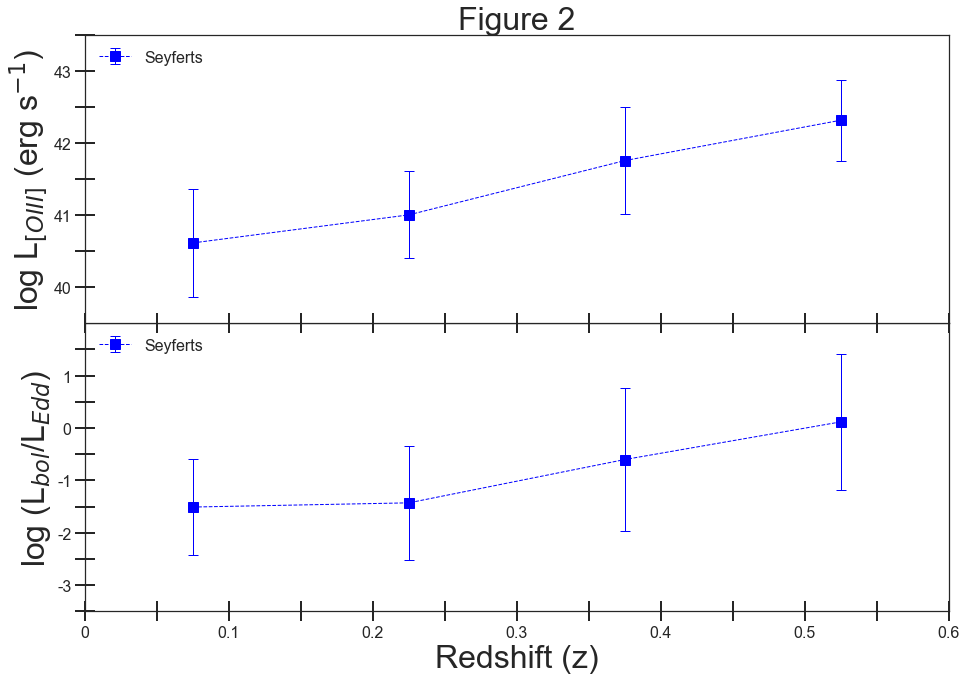

In [144]:
fig = plt.figure()

ax2 = fig.add_axes([0, 0, 2, 1], 
                   ylim = (-3.5, 2), xlim = (0, 0.6))
ax1 = fig.add_axes([0, 1, 2, 1],
                   xticklabels=[],  ylim = (39.5, 43.5), xlim = (0, 0.6) )


ax1.errorbar(mean_redshifts, mean_OIII_log_lum, std_OIII_log_lum, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 5, label = 'Seyferts')
ax1.set_yticks([40, 40.5, 41, 41.5, 42, 42.5, 43, 43.5])
ax1.set_yticklabels([40, '', 41, '', 42, '', 43, ''], fontsize = 16)
ax1.set_xticks(np.arange(0, 0.65, 0.05))
ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)

ax2.errorbar(mean_redshifts, mean_log_edd_ratio, std_log_edd_ratio, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 5, label = 'Seyferts')
ax2.set_yticks([-3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5])
ax2.set_yticklabels(['', -3, '', -2, '', -1, '', 0, '', 1, ''], fontsize = 16)
ax2.set_xticks(np.arange(0, 0.65, 0.05))
ax2.set_xticklabels([0, '', 0.1, '', 0.2, '', 0.3, '', 0.4, '', 0.5, '', 0.6], fontsize = 16)
ax2.set_ylabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)
ax2.set_xlabel('Redshift (z)', fontsize = 32)

ax1.set_title('Figure 2', fontsize = 32)

ax1.legend(loc = 2, fontsize = 16)
ax2.legend(loc = 2, fontsize = 16)

ax1.tick_params(length = 20, width = 2, direction = 'inout')
ax2.tick_params(length = 20, width = 2, direction = 'inout')

plt.show()

In [47]:
##############################################################
############################################################## END FIG 2
##############################################################

In [48]:
##############################################################
############################################################## START FIG 3
##############################################################

In [49]:
zbin1_log_OIII_sigma = np.log10(OIII_sigma_array_zbin1_good)
zbin2_log_OIII_sigma = np.log10(OIII_sigma_array_zbin2_good)
zbin3_log_OIII_sigma = np.log10(OIII_sigma_array_zbin3_good)
zbin4_log_OIII_sigma = np.log10(OIII_sigma_array_zbin4_good)

zbin1_log_sigma_stars = np.log10(zbin1_sigma_stars)
zbin2_log_sigma_stars = np.log10(zbin2_sigma_stars)
zbin3_log_sigma_stars = np.log10(zbin3_sigma_stars)
zbin4_log_sigma_stars = np.log10(zbin4_sigma_stars)

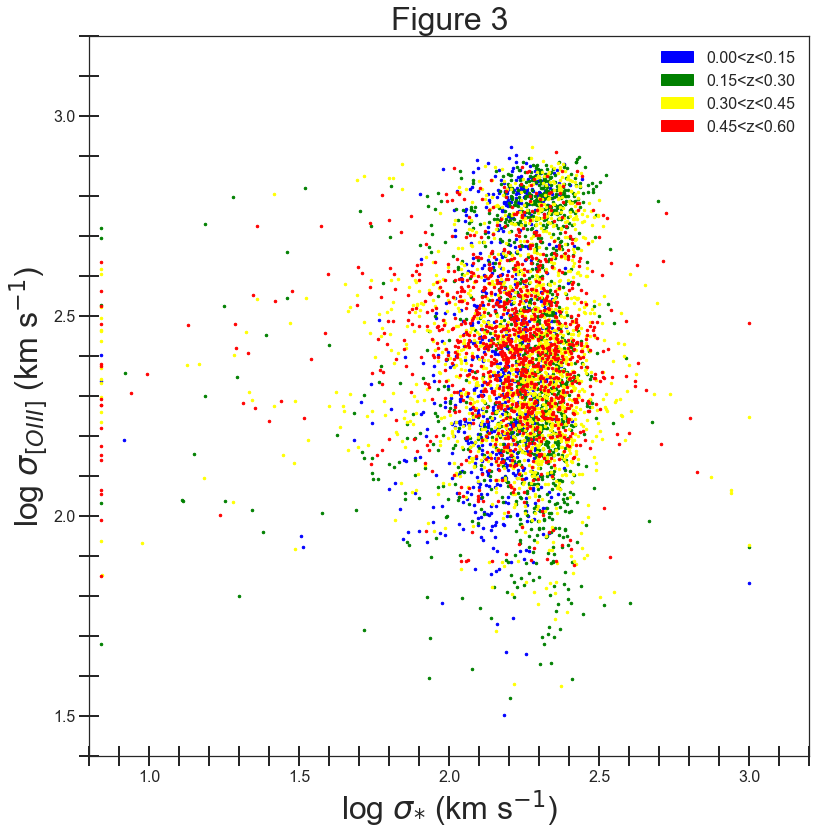

In [140]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1], ylim = (1.4, 3.2), xlim = (0.8, 3.2) )

ax1.plot(zbin1_log_sigma_stars, zbin1_log_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_log_sigma_stars, zbin2_log_OIII_sigma, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_log_sigma_stars, zbin3_log_OIII_sigma, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_log_sigma_stars, zbin4_log_OIII_sigma, color = 'red',    linestyle = '', marker = '.', ms = 5)

ax1.set_yticks(np.arange(1.4, 3.3, 0.1))
ax1.set_yticklabels(['', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_xticks(np.arange(0.8, 3.3, 0.1))
ax1.set_xticklabels(['', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_ylabel(r'log $\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'log $\sigma$$_{*}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

ax1.tick_params(length = 20, width = 2, direction = 'inout')

plt.title('Figure 3', fontsize = 32)

plt.show()

In [51]:
##############################################################
############################################################## END FIG 3
##############################################################

In [52]:
##############################################################
############################################################## START FIG 4
##############################################################

In [53]:
zbin1_results_v2 = zbin1_results[select_good_zbin1]
zbin2_results_v2 = zbin2_results[select_good_zbin2]
zbin3_results_v2 = zbin3_results[select_good_zbin3]
zbin4_results_v2 = zbin4_results[select_good_zbin4]

zbin1_flags = zbin1_results_v2['FLAG']
zbin2_flags = zbin2_results_v2['FLAG']
zbin3_flags = zbin3_results_v2['FLAG']
zbin4_flags = zbin4_results_v2['FLAG']

zbin1_select_double_gaussian = (zbin1_flags == 2) | (zbin1_flags == 3)
zbin2_select_double_gaussian = (zbin2_flags == 2) | (zbin2_flags == 3)
zbin3_select_double_gaussian = (zbin3_flags == 2) | (zbin3_flags == 3)
zbin4_select_double_gaussian = (zbin4_flags == 2) | (zbin4_flags == 3)

zbin1_select_single_gaussian = (zbin1_flags == 0) | (zbin1_flags == 1) | (zbin1_flags == 4)
zbin2_select_single_gaussian = (zbin2_flags == 0) | (zbin2_flags == 1) | (zbin2_flags == 4)
zbin3_select_single_gaussian = (zbin3_flags == 0) | (zbin3_flags == 1) | (zbin3_flags == 4)
zbin4_select_single_gaussian = (zbin4_flags == 0) | (zbin4_flags == 1) | (zbin4_flags == 4)

#have all values, first calculate ratios then slice and average

zbin1_sigma_ratio = OIII_sigma_array_zbin1_good / zbin1_sigma_stars
zbin2_sigma_ratio = OIII_sigma_array_zbin2_good / zbin2_sigma_stars
zbin3_sigma_ratio = OIII_sigma_array_zbin3_good / zbin3_sigma_stars
zbin4_sigma_ratio = OIII_sigma_array_zbin4_good / zbin4_sigma_stars

zbin1_log_sigma_ratio = np.log10(zbin1_sigma_ratio)
zbin2_log_sigma_ratio = np.log10(zbin2_sigma_ratio)
zbin3_log_sigma_ratio = np.log10(zbin3_sigma_ratio)
zbin4_log_sigma_ratio = np.log10(zbin4_sigma_ratio)

##############################################################

zbin1_sg_log_sigma_ratio = zbin1_log_sigma_ratio[zbin1_select_single_gaussian]
zbin2_sg_log_sigma_ratio = zbin2_log_sigma_ratio[zbin2_select_single_gaussian]
zbin3_sg_log_sigma_ratio = zbin3_log_sigma_ratio[zbin3_select_single_gaussian]
zbin4_sg_log_sigma_ratio = zbin4_log_sigma_ratio[zbin4_select_single_gaussian]

zbin1_dg_log_sigma_ratio = zbin1_log_sigma_ratio[zbin1_select_double_gaussian]
zbin2_dg_log_sigma_ratio = zbin2_log_sigma_ratio[zbin2_select_double_gaussian]
zbin3_dg_log_sigma_ratio = zbin3_log_sigma_ratio[zbin3_select_double_gaussian]
zbin4_dg_log_sigma_ratio = zbin4_log_sigma_ratio[zbin4_select_double_gaussian]

zbin1_sg_OIII_log_lum = zbin1_OIII_log_lum_array[zbin1_select_single_gaussian]
zbin2_sg_OIII_log_lum = zbin2_OIII_log_lum_array[zbin2_select_single_gaussian]
zbin3_sg_OIII_log_lum = zbin3_OIII_log_lum_array[zbin3_select_single_gaussian]
zbin4_sg_OIII_log_lum = zbin4_OIII_log_lum_array[zbin4_select_single_gaussian]

zbin1_dg_OIII_log_lum = zbin1_OIII_log_lum_array[zbin1_select_double_gaussian]
zbin2_dg_OIII_log_lum = zbin2_OIII_log_lum_array[zbin2_select_double_gaussian]
zbin3_dg_OIII_log_lum = zbin3_OIII_log_lum_array[zbin3_select_double_gaussian]
zbin4_dg_OIII_log_lum = zbin4_OIII_log_lum_array[zbin4_select_double_gaussian]

In [54]:
sg_log_sigma_ratio = np.concatenate( ( zbin1_sg_log_sigma_ratio, zbin2_sg_log_sigma_ratio, 
                                       zbin3_sg_log_sigma_ratio, zbin4_sg_log_sigma_ratio ) )

dg_log_sigma_ratio = np.concatenate( ( zbin1_dg_log_sigma_ratio, zbin2_dg_log_sigma_ratio, 
                                       zbin3_dg_log_sigma_ratio, zbin4_dg_log_sigma_ratio ) )

##############################################################

sg_OIII_log_lum = np.concatenate( ( zbin1_sg_OIII_log_lum, zbin2_sg_OIII_log_lum, 
                                    zbin3_sg_OIII_log_lum, zbin4_sg_OIII_log_lum ) )

dg_OIII_log_lum = np.concatenate( ( zbin1_dg_OIII_log_lum, zbin2_dg_OIII_log_lum, 
                                    zbin3_dg_OIII_log_lum, zbin4_dg_OIII_log_lum ) )

In [55]:
select_sg_lumbin1 = ( sg_OIII_log_lum < 40 )
select_sg_lumbin2 = ( sg_OIII_log_lum > 40 ) & ( sg_OIII_log_lum < 41)
select_sg_lumbin3 = ( sg_OIII_log_lum > 41 ) & ( sg_OIII_log_lum < 42 )
select_sg_lumbin4 = ( sg_OIII_log_lum > 42 ) & ( sg_OIII_log_lum < 43 )
select_sg_lumbin5 = ( sg_OIII_log_lum > 43 )


select_dg_lumbin1 = ( dg_OIII_log_lum < 40 )
select_dg_lumbin2 = ( dg_OIII_log_lum > 40 ) & ( dg_OIII_log_lum < 41)
select_dg_lumbin3 = ( dg_OIII_log_lum > 41 ) & ( dg_OIII_log_lum < 42 )
select_dg_lumbin4 = ( dg_OIII_log_lum > 42 ) & ( dg_OIII_log_lum < 43 )
select_dg_lumbin5 = ( dg_OIII_log_lum > 43 )

In [56]:
lumbin1_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin1]
lumbin2_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin2]
lumbin3_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin3]
lumbin4_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin4]
lumbin5_sg_OIII_log_lum  = sg_OIII_log_lum[select_sg_lumbin5]

##############################################################

lumbin1_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin1]
lumbin2_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin2]
lumbin3_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin3]
lumbin4_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin4]
lumbin5_sg_log_sigma_ratio  = sg_log_sigma_ratio[select_sg_lumbin5]

##############################################################
##############################################################

lumbin1_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin1]
lumbin2_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin2]
lumbin3_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin3]
lumbin4_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin4]
lumbin5_dg_OIII_log_lum  = dg_OIII_log_lum[select_dg_lumbin5]

##############################################################

lumbin1_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin1]
lumbin2_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin2]
lumbin3_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin3]
lumbin4_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin4]
lumbin5_dg_log_sigma_ratio  = dg_log_sigma_ratio[select_dg_lumbin5]

In [57]:
lumbin1_sg_mean_log_sigma_ratio = np.mean(lumbin1_sg_log_sigma_ratio)
lumbin2_sg_mean_log_sigma_ratio = np.mean(lumbin2_sg_log_sigma_ratio)
lumbin3_sg_mean_log_sigma_ratio = np.mean(lumbin3_sg_log_sigma_ratio)
lumbin4_sg_mean_log_sigma_ratio = np.mean(lumbin4_sg_log_sigma_ratio)
lumbin5_sg_mean_log_sigma_ratio = np.mean(lumbin5_sg_log_sigma_ratio)

##############################################################

lumbin1_sg_std_log_sigma_ratio = np.std(lumbin1_sg_log_sigma_ratio)
lumbin2_sg_std_log_sigma_ratio = np.std(lumbin2_sg_log_sigma_ratio)
lumbin3_sg_std_log_sigma_ratio = np.std(lumbin3_sg_log_sigma_ratio)
lumbin4_sg_std_log_sigma_ratio = np.std(lumbin4_sg_log_sigma_ratio)
lumbin5_sg_std_log_sigma_ratio = np.std(lumbin5_sg_log_sigma_ratio)

##############################################################
##############################################################

lumbin1_dg_mean_log_sigma_ratio = np.mean(lumbin1_dg_log_sigma_ratio)
lumbin2_dg_mean_log_sigma_ratio = np.mean(lumbin2_dg_log_sigma_ratio)
lumbin3_dg_mean_log_sigma_ratio = np.mean(lumbin3_dg_log_sigma_ratio)
lumbin4_dg_mean_log_sigma_ratio = np.mean(lumbin4_dg_log_sigma_ratio)
lumbin5_dg_mean_log_sigma_ratio = np.mean(lumbin5_dg_log_sigma_ratio)

##############################################################

lumbin1_dg_std_log_sigma_ratio = np.std(lumbin1_dg_log_sigma_ratio)
lumbin2_dg_std_log_sigma_ratio = np.std(lumbin2_dg_log_sigma_ratio)
lumbin3_dg_std_log_sigma_ratio = np.std(lumbin3_dg_log_sigma_ratio)
lumbin4_dg_std_log_sigma_ratio = np.std(lumbin4_dg_log_sigma_ratio)
lumbin5_dg_std_log_sigma_ratio = np.std(lumbin5_dg_log_sigma_ratio)

In [58]:
fig4_xaxis = np.array([39.5, 40.5, 41.5, 42.5, 43.5])
fig4_sg_yvalues = np.array([lumbin1_sg_mean_log_sigma_ratio, lumbin2_sg_mean_log_sigma_ratio, 
                            lumbin3_sg_mean_log_sigma_ratio, lumbin4_sg_mean_log_sigma_ratio,
                            lumbin5_sg_mean_log_sigma_ratio])

fig4_sg_yerror  = np.array([lumbin1_sg_std_log_sigma_ratio, lumbin2_sg_std_log_sigma_ratio, 
                            lumbin3_sg_std_log_sigma_ratio, lumbin4_sg_std_log_sigma_ratio,
                            lumbin5_sg_std_log_sigma_ratio])

fig4_dg_yvalues = np.array([lumbin1_dg_mean_log_sigma_ratio, lumbin2_dg_mean_log_sigma_ratio, 
                            lumbin3_dg_mean_log_sigma_ratio, lumbin4_dg_mean_log_sigma_ratio,
                            lumbin5_dg_mean_log_sigma_ratio])

fig4_dg_yerror  = np.array([lumbin1_dg_std_log_sigma_ratio, lumbin2_dg_std_log_sigma_ratio, 
                            lumbin3_dg_std_log_sigma_ratio, lumbin4_dg_std_log_sigma_ratio,
                            lumbin5_dg_std_log_sigma_ratio])

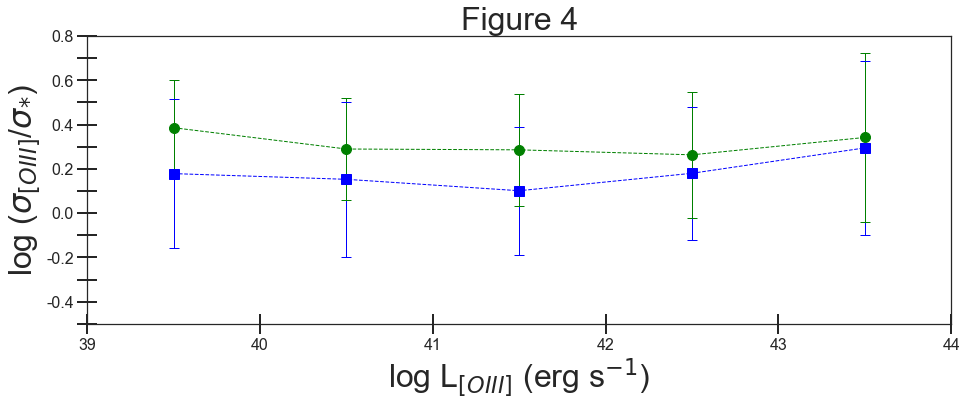

In [139]:
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 2, 1],)

ax1.errorbar(fig4_xaxis, fig4_sg_yvalues, fig4_sg_yerror, color = 'blue', linewidth = 1, linestyle = '--', marker = 's', ms = 10, capsize = 5, label = 'Seyferts')
ax1.errorbar(fig4_xaxis, fig4_dg_yvalues, fig4_dg_yerror, color = 'green', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5, label = 'Seyferts')


ax1.set_yticks(np.arange(-0.5, 0.9, 0.1))
ax1.set_yticklabels(['', -0.4, '', -0.2, '', 0.0, '', 0.2, '', 0.4, '', 0.6, '', 0.8], fontsize = 16)
ax1.set_ylabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)

ax1.set_xticks([39, 40, 41, 42, 43, 44])
ax1.set_xticklabels([39, 40, 41, 42, 43, 44], fontsize = 16)
ax1.set_xlabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)


ax1.set_title('Figure 4', fontsize = 32)

ax1.tick_params(length = 20, width = 2, direction = 'inout')

plt.show()

In [60]:
##############################################################
############################################################## END FIG 4
##############################################################

In [61]:
##############################################################
############################################################## START FIG 5
##############################################################

In [62]:
OIII_log_lum = np.concatenate((zbin1_OIII_log_lum_array, zbin2_OIII_log_lum_array, 
                               zbin3_OIII_log_lum_array, zbin4_OIII_log_lum_array))

log_OIII_sigma = np.concatenate((zbin1_log_OIII_sigma, zbin2_log_OIII_sigma, 
                                 zbin3_log_OIII_sigma, zbin4_log_OIII_sigma))

In [63]:
select_lumbin1 = ( OIII_log_lum < 40 )
select_lumbin2 = ( OIII_log_lum > 40 ) & ( OIII_log_lum < 41 )
select_lumbin3 = ( OIII_log_lum > 41 ) & ( OIII_log_lum < 42 )
select_lumbin4 = ( OIII_log_lum > 42 ) & ( OIII_log_lum < 43 )
select_lumbin5 = ( OIII_log_lum > 43 )
# select_lumbin6 = ( OIII_log_lum > 43.5 )

In [64]:
lumbin1_log_OIII_sigma = log_OIII_sigma[select_lumbin1]
lumbin2_log_OIII_sigma = log_OIII_sigma[select_lumbin2]
lumbin3_log_OIII_sigma = log_OIII_sigma[select_lumbin3]
lumbin4_log_OIII_sigma = log_OIII_sigma[select_lumbin4]
lumbin5_log_OIII_sigma = log_OIII_sigma[select_lumbin5]

mean_log_OIII_sigma_fig5 = np.array([np.mean(lumbin1_log_OIII_sigma), np.mean(lumbin2_log_OIII_sigma),
                                     np.mean(lumbin3_log_OIII_sigma), np.mean(lumbin4_log_OIII_sigma),
                                     np.mean(lumbin5_log_OIII_sigma)])

std_log_OIII_sigma_fig5  = np.array([np.std(lumbin1_log_OIII_sigma), np.std(lumbin2_log_OIII_sigma),
                                     np.std(lumbin3_log_OIII_sigma), np.std(lumbin4_log_OIII_sigma),
                                     np.std(lumbin5_log_OIII_sigma)])

log_lum_yaxis_fig5 = np.array([39.5, 40.5, 41.5, 42.5, 43.5])

In [65]:
log_edd_ratio   = np.concatenate((zbin1_log_edd_ratio, zbin2_log_edd_ratio,
                                  zbin3_log_edd_ratio, zbin4_log_edd_ratio))

log_sigma_ratio = np.concatenate((zbin1_log_sigma_ratio, zbin2_log_sigma_ratio,
                                  zbin3_log_sigma_ratio, zbin4_log_sigma_ratio))

In [66]:
array_summary(log_edd_ratio)

             Count:   4941
              Mean:   -0.780427930783711
            Median:   -0.9711904510227725
Standard Deviation:   1.3747369562637974
           Minimum:   -4.784155518547256
           Maximum:   7.000205715282162


In [67]:
select_eddbin1  = ( log_edd_ratio < -3.5 )
select_eddbin2  = ( log_edd_ratio < -2.5 ) & ( log_edd_ratio > -3.5 )
select_eddbin3  = ( log_edd_ratio < -1.5 ) & ( log_edd_ratio > -2.5 )
select_eddbin4  = ( log_edd_ratio < -0.5 ) & ( log_edd_ratio > -1.5 )
select_eddbin5  = ( log_edd_ratio <  0.5 ) & ( log_edd_ratio > -0.5 )
select_eddbin6  = ( log_edd_ratio <  1.5 ) & ( log_edd_ratio >  0.5 )
select_eddbin7  = ( log_edd_ratio <  2.5 ) & ( log_edd_ratio >  1.5 )
select_eddbin8  = ( log_edd_ratio <  3.5 ) & ( log_edd_ratio >  2.5 )
select_eddbin9  = ( log_edd_ratio <  4.5 ) & ( log_edd_ratio >  3.5 )
select_eddbin10 = ( log_edd_ratio <  5.5 ) & ( log_edd_ratio >  4.5 )
select_eddbin11 = ( log_edd_ratio >  5.5 )

In [68]:
eddbin1_log_sigma_ratio  = log_sigma_ratio[select_eddbin1]
eddbin2_log_sigma_ratio  = log_sigma_ratio[select_eddbin2]
eddbin3_log_sigma_ratio  = log_sigma_ratio[select_eddbin3]
eddbin4_log_sigma_ratio  = log_sigma_ratio[select_eddbin4]
eddbin5_log_sigma_ratio  = log_sigma_ratio[select_eddbin5]
eddbin6_log_sigma_ratio  = log_sigma_ratio[select_eddbin6]
eddbin7_log_sigma_ratio  = log_sigma_ratio[select_eddbin7]
eddbin8_log_sigma_ratio  = log_sigma_ratio[select_eddbin8]
eddbin9_log_sigma_ratio  = log_sigma_ratio[select_eddbin9]
eddbin10_log_sigma_ratio = log_sigma_ratio[select_eddbin10]
eddbin11_log_sigma_ratio = log_sigma_ratio[select_eddbin11]

##############################################################

log_edd_ratio_yaxis_fig5 = np.array([-4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6])

##############################################################

mean_log_sigma_ratio_fig5 = np.array([np.mean(eddbin1_log_sigma_ratio), np.mean(eddbin2_log_sigma_ratio),
                                      np.mean(eddbin3_log_sigma_ratio), np.mean(eddbin4_log_sigma_ratio),
                                      np.mean(eddbin5_log_sigma_ratio), np.mean(eddbin6_log_sigma_ratio),
                                      np.mean(eddbin7_log_sigma_ratio), np.mean(eddbin8_log_sigma_ratio),
                                      np.mean(eddbin9_log_sigma_ratio), np.mean(eddbin10_log_sigma_ratio),
                                      np.mean(eddbin11_log_sigma_ratio)])

std_log_sigma_ratio_fig5 = np.array([np.std(eddbin1_log_sigma_ratio), np.std(eddbin2_log_sigma_ratio),
                                     np.std(eddbin3_log_sigma_ratio), np.std(eddbin4_log_sigma_ratio),
                                     np.std(eddbin5_log_sigma_ratio), np.std(eddbin6_log_sigma_ratio),
                                     np.std(eddbin7_log_sigma_ratio), np.std(eddbin8_log_sigma_ratio),
                                     np.std(eddbin9_log_sigma_ratio), np.std(eddbin10_log_sigma_ratio),
                                     np.std(eddbin11_log_sigma_ratio)])

##############################################################

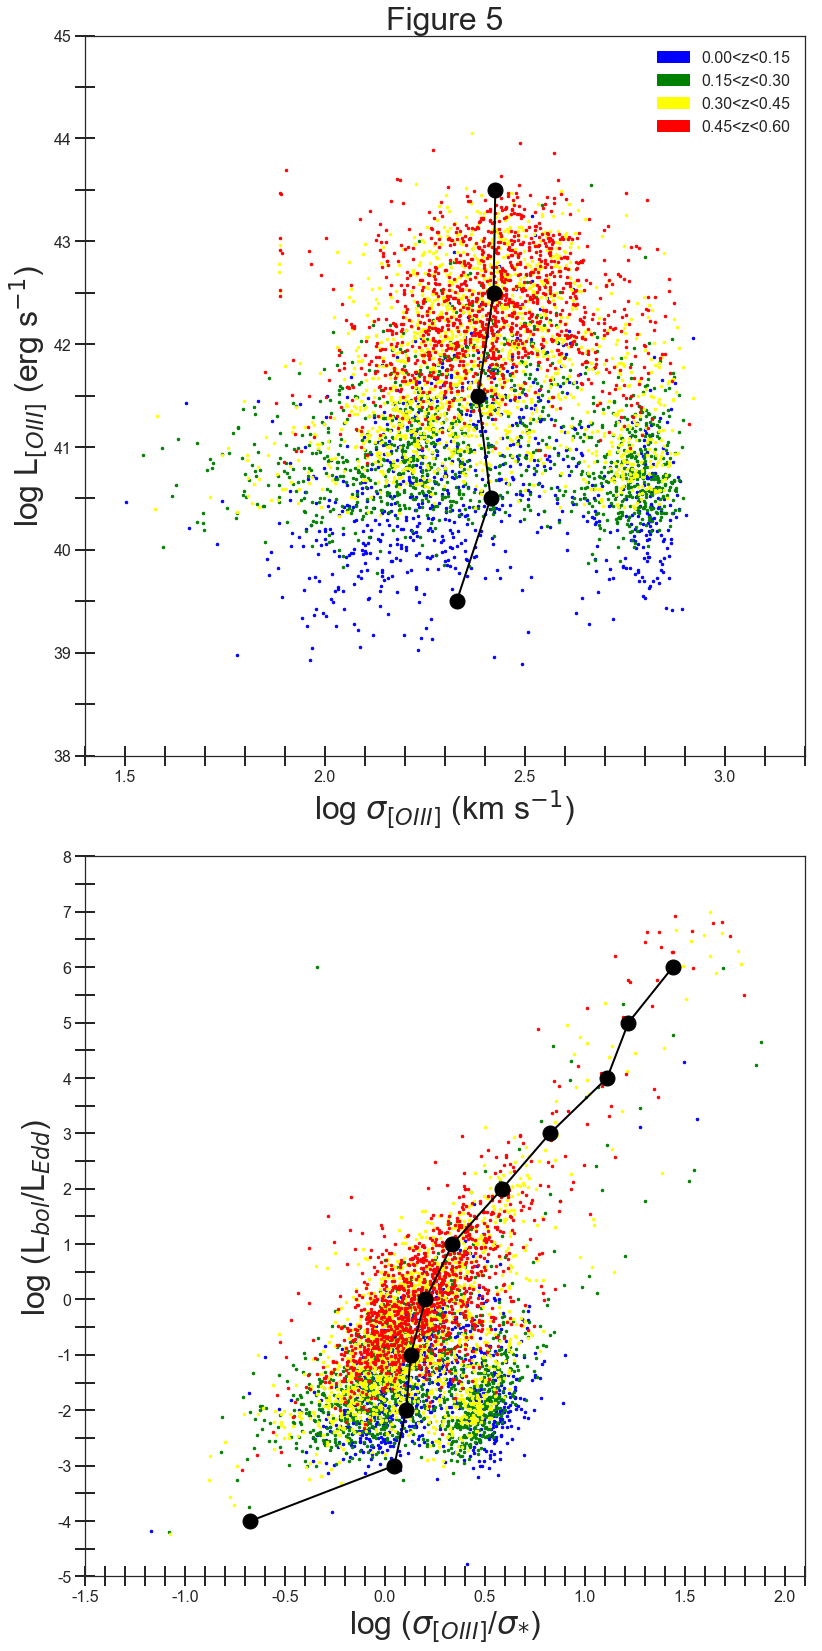

In [138]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1],     xlim = ( 1.4, 3.2), ylim = (38, 45) )
ax2 = fig.add_axes([0, -1.14, 1, 1], xlim = (-1.5, 2.1), ylim = (-5,  8))

ax1.plot(zbin1_log_OIII_sigma, zbin1_OIII_log_lum_array, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_log_OIII_sigma, zbin2_OIII_log_lum_array, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_log_OIII_sigma, zbin3_OIII_log_lum_array, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_log_OIII_sigma, zbin4_OIII_log_lum_array, color = 'red',    linestyle = '', marker = '.', ms = 5)
ax1.errorbar(mean_log_OIII_sigma_fig5, log_lum_yaxis_fig5, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

ax1.set_xticks(np.arange(1.4, 3.3, 0.1))
ax1.set_xticklabels(['', 1.5, '', '', '', '', 2.0, '', '', '', '', 2.5, '', '', '', '', 3.0, '', ''], fontsize = 16)

ax1.set_yticks(np.arange(38, 45.5, 0.5))
ax1.set_yticklabels([38, '', 39, '', 40, '', 41, '', 42, '', 43, '', 44, '', 45], fontsize = 16)

ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'log $\sigma$$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

ax1.set_title('Figure 5', fontsize = 32)

##############################################################

ax2.plot(zbin1_log_sigma_ratio, zbin1_log_edd_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2.plot(zbin2_log_sigma_ratio, zbin2_log_edd_ratio, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax2.plot(zbin3_log_sigma_ratio, zbin3_log_edd_ratio, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax2.plot(zbin4_log_sigma_ratio, zbin4_log_edd_ratio, color = 'red',    linestyle = '', marker = '.', ms = 5)
ax2.errorbar(mean_log_sigma_ratio_fig5, log_edd_ratio_yaxis_fig5, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

ax2.set_xticks(np.arange(-1.5, 2.2, 0.1))
ax2.set_xticklabels([-1.5, '', '', '', '', -1.0, '', '', '', '', -0.5, '', '', '', '', 0.0, '', '', '', '', 0.5, '', '', '', '', 1.0, '', '', '', '', 1.5, '', '', '', '', 2.0, ''], fontsize = 16)

ax2.set_yticks(np.arange(-5, 8.5, 0.5))
ax2.set_yticklabels([-5, '', -4, '', -3, '', -2, '', -1, '', 0, '', 1, '', 2, '', 3, '', 4, '', 5, '', 6, '', 7, '', 8], fontsize = 16)

ax2.set_xlabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)
ax2.set_ylabel(r'log (L$_{bol}$/L$_{Edd}$)', fontsize = 32)

ax1.tick_params(length = 20, width = 2, direction = 'inout')
ax2.tick_params(length = 20, width = 2, direction = 'inout')

plt.show()

In [148]:
print(mean_log_sigma_ratio_fig5)
print(std_log_sigma_ratio_fig5)
print('')
print(mean_log_OIII_sigma_fig5)
print(std_log_OIII_sigma_fig5)

[-0.67253956  0.04720877  0.1065587   0.12914186  0.20287336  0.3380519
  0.58675199  0.82577238  1.11141629  1.21787089  1.43950649]
[0.49067535 0.35041535 0.31530853 0.24671594 0.20426628 0.21346638
 0.24260272 0.25476229 0.23105362 0.31181177 0.375719  ]

[2.32939936 2.41457092 2.38304797 2.42183088 2.42605721]
[0.30592176 0.31768436 0.23122587 0.1636282  0.14775339]


In [178]:
spearmanr(np.concatenate((zbin1_log_OIII_sigma, zbin2_log_OIII_sigma, zbin3_log_OIII_sigma, zbin4_log_OIII_sigma)), np.concatenate((zbin1_OIII_log_lum_array, zbin2_OIII_log_lum_array, zbin3_OIII_log_lum_array, zbin4_OIII_log_lum_array)))

SpearmanrResult(correlation=0.06685245879554737, pvalue=2.560117051721655e-06)

In [70]:
############################################################## SpearmanrResult(correlation=0.06685245879554737, pvalue=2.560117051721655e-06)
############################################################## END FIG 5
############################################################## SpearmanrResult(correlation=0.8999999999999998, pvalue=0.03738607346849874)

In [71]:
##############################################################
############################################################## START FIG 5
##############################################################

In [72]:
zbin1_vel_shift = zbin1_results_v2['VELSHIFT']
zbin2_vel_shift = zbin2_results_v2['VELSHIFT']
zbin3_vel_shift = zbin3_results_v2['VELSHIFT']
zbin4_vel_shift = zbin4_results_v2['VELSHIFT']

vel_shift = np.concatenate((zbin1_vel_shift, zbin2_vel_shift, zbin3_vel_shift, zbin4_vel_shift))

In [73]:
lumbin1_vel_shift = vel_shift[select_lumbin1]
lumbin2_vel_shift = vel_shift[select_lumbin2]
lumbin3_vel_shift = vel_shift[select_lumbin3]
lumbin4_vel_shift = vel_shift[select_lumbin4]
lumbin5_vel_shift = vel_shift[select_lumbin5]

# lumbin1_vel_shift = lumbin1_vel_shift[lumbin1_vel_shift != 0]
# lumbin2_vel_shift = lumbin2_vel_shift[lumbin2_vel_shift != 0]
# lumbin3_vel_shift = lumbin3_vel_shift[lumbin3_vel_shift != 0]
# lumbin4_vel_shift = lumbin4_vel_shift[lumbin4_vel_shift != 0]
# lumbin5_vel_shift = lumbin5_vel_shift[lumbin5_vel_shift != 0]
# lumbin6_vel_shift = lumbin6_vel_shift[lumbin6_vel_shift != 0]

In [74]:
mean_vel_shift_fig6 = np.array([np.mean(lumbin1_vel_shift), np.mean(lumbin2_vel_shift),
                                np.mean(lumbin3_vel_shift), np.mean(lumbin4_vel_shift),
                                np.mean(lumbin5_vel_shift)])

std_vel_shift_fig6 = np.array([np.std(lumbin1_vel_shift), np.std(lumbin2_vel_shift),
                               np.std(lumbin3_vel_shift), np.std(lumbin4_vel_shift),
                               np.std(lumbin5_vel_shift)])

log_lum_yaxis_fig6 = log_lum_yaxis_fig5

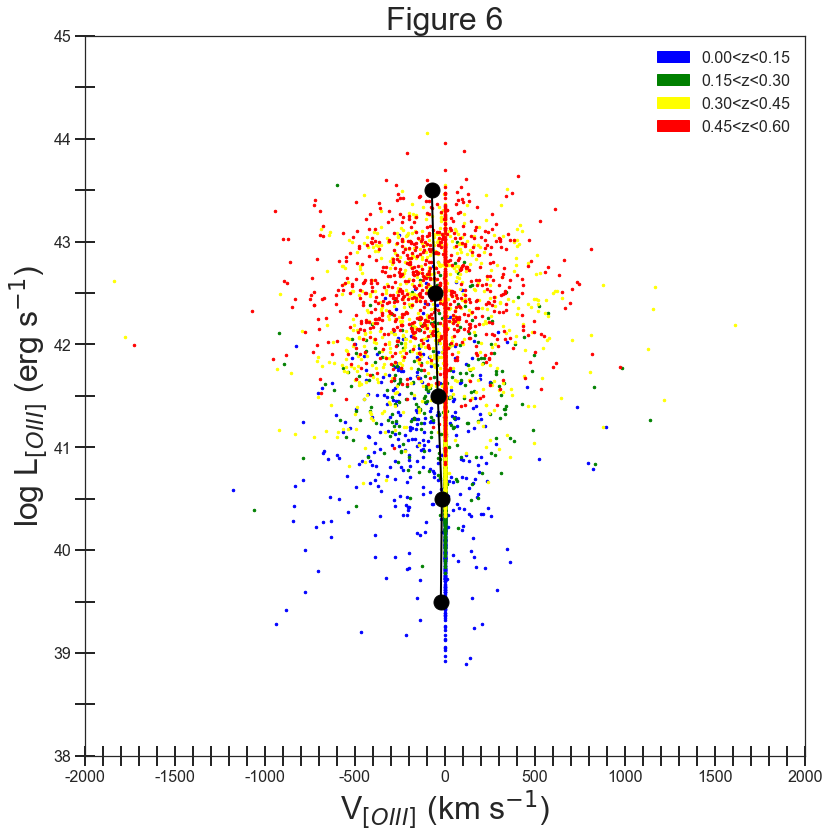

In [137]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1], xlim = (-2000, 2000), ylim = (38, 45) )
# ax2 = fig.add_axes([0, -1.14, 1, 1], xlim = (-1.5, 2.1), ylim = (-5,  8))

ax1.plot(zbin1_vel_shift, zbin1_OIII_log_lum_array, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin2_vel_shift, zbin2_OIII_log_lum_array, color = 'green',  linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin3_vel_shift, zbin3_OIII_log_lum_array, color = 'yellow', linestyle = '', marker = '.', ms = 5)
ax1.plot(zbin4_vel_shift, zbin4_OIII_log_lum_array, color = 'red',    linestyle = '', marker = '.', ms = 5)
ax1.errorbar(mean_vel_shift_fig6, log_lum_yaxis_fig6, color = 'black', linewidth = 2, linestyle = '-', marker = 'o', ms = 15, capsize = 5)

ax1.set_xticks(np.arange(-2000, 2100, 100))
ax1.set_xticklabels([-2000, '', '', '', '', -1500, '', '', '', '', -1000, '', '', '', '', -500, '', '', '', '', 0, '', '', '', '', 500, '', '', '', '', 1000, '', '', '', '', 1500, '', '', '', '', 2000], fontsize = 16)

ax1.set_yticks(np.arange(38, 45.5, 0.5))
ax1.set_yticklabels([38, '', 39, '', 40, '', 41, '', 42, '', 43, '', 44, '', 45], fontsize = 16)

ax1.set_ylabel(r'log L$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

blue_patch   = mpatches.Patch(color='blue',   label = '0.00<z<0.15')
green_patch  = mpatches.Patch(color='green',  label = '0.15<z<0.30')
yellow_patch = mpatches.Patch(color='yellow', label = '0.30<z<0.45')
red_patch    = mpatches.Patch(color='red',    label = '0.45<z<0.60')

ax1.legend(handles = [blue_patch, green_patch, yellow_patch, red_patch], fontsize = 16)

ax1.set_title('Figure 6', fontsize = 32)

ax1.tick_params(length = 20, width = 2, direction = 'inout')

plt.show()

In [76]:
##############################################################
############################################################## END FIG 6
##############################################################

In [77]:
##############################################################
############################################################## START FIG 7
##############################################################

In [78]:
#stitch together sigma OIII, and vel_shift, and flags

In [79]:
OIII_sigma    = np.concatenate((OIII_sigma_array_zbin1_good, OIII_sigma_array_zbin2_good,
                             OIII_sigma_array_zbin3_good, OIII_sigma_array_zbin4_good))

vel_shift     = np.concatenate((zbin1_vel_shift, zbin2_vel_shift,
                                zbin3_vel_shift, zbin4_vel_shift))

results_flags = np.concatenate((zbin1_flags, zbin2_flags,
                                zbin3_flags, zbin4_flags))

In [80]:
select_sg_fig7 = ( results_flags == 0 ) | ( results_flags == 1 ) | ( results_flags == 4 )
select_dg_fig7 = ( results_flags == 2 ) | ( results_flags == 3 )

In [81]:
sg_OIII_sigma = OIII_sigma[select_sg_fig7]
dg_OIII_sigma = OIII_sigma[select_dg_fig7]

sg_vel_shift  = vel_shift[select_sg_fig7]
dg_vel_shift  = vel_shift[select_dg_fig7]

In [82]:
select_sg_sigmabin1 = (sg_OIII_sigma < 200)
select_sg_sigmabin2 = (sg_OIII_sigma < 300) & (sg_OIII_sigma > 200)
select_sg_sigmabin3 = (sg_OIII_sigma < 400) & (sg_OIII_sigma > 300)
select_sg_sigmabin4 = (sg_OIII_sigma < 500) & (sg_OIII_sigma > 400)
select_sg_sigmabin5 = (sg_OIII_sigma < 600) & (sg_OIII_sigma > 500)
select_sg_sigmabin6 = (sg_OIII_sigma < 700) & (sg_OIII_sigma > 600)
select_sg_sigmabin7 = (sg_OIII_sigma > 700)

select_dg_sigmabin1 = (dg_OIII_sigma < 200)
select_dg_sigmabin2 = (dg_OIII_sigma < 300) & (dg_OIII_sigma > 200)
select_dg_sigmabin3 = (dg_OIII_sigma < 400) & (dg_OIII_sigma > 300)
select_dg_sigmabin4 = (dg_OIII_sigma < 500) & (dg_OIII_sigma > 400)
select_dg_sigmabin5 = (dg_OIII_sigma < 600) & (dg_OIII_sigma > 500)
select_dg_sigmabin6 = (dg_OIII_sigma < 700) & (dg_OIII_sigma > 600)
select_dg_sigmabin7 = (dg_OIII_sigma > 700)

In [83]:
sigmabin1_sg_vel_shift = sg_vel_shift[select_sg_sigmabin1]
sigmabin2_sg_vel_shift = sg_vel_shift[select_sg_sigmabin2]
sigmabin3_sg_vel_shift = sg_vel_shift[select_sg_sigmabin3]
sigmabin4_sg_vel_shift = sg_vel_shift[select_sg_sigmabin4]
sigmabin5_sg_vel_shift = sg_vel_shift[select_sg_sigmabin5]
sigmabin6_sg_vel_shift = sg_vel_shift[select_sg_sigmabin6]
sigmabin7_sg_vel_shift = sg_vel_shift[select_sg_sigmabin7]

##############################################################

sigmabin1_dg_vel_shift = dg_vel_shift[select_dg_sigmabin1]
sigmabin2_dg_vel_shift = dg_vel_shift[select_dg_sigmabin2]
sigmabin3_dg_vel_shift = dg_vel_shift[select_dg_sigmabin3]
sigmabin4_dg_vel_shift = dg_vel_shift[select_dg_sigmabin4]
sigmabin5_dg_vel_shift = dg_vel_shift[select_dg_sigmabin5]
sigmabin6_dg_vel_shift = dg_vel_shift[select_dg_sigmabin6]
sigmabin7_dg_vel_shift = dg_vel_shift[select_dg_sigmabin7]

In [84]:
mean_sg_velshift_fig7  = np.array([np.mean(sigmabin1_sg_vel_shift), np.mean(sigmabin2_sg_vel_shift), np.mean(sigmabin3_sg_vel_shift),
                                   np.mean(sigmabin4_sg_vel_shift), np.mean(sigmabin5_sg_vel_shift), np.mean(sigmabin6_sg_vel_shift), 
                                   np.mean(sigmabin7_sg_vel_shift)])

std_sg_velshift_fig7  = np.array([np.std(sigmabin1_sg_vel_shift), np.std(sigmabin2_sg_vel_shift), np.std(sigmabin3_sg_vel_shift),
                                  np.std(sigmabin4_sg_vel_shift), np.std(sigmabin5_sg_vel_shift), np.std(sigmabin6_sg_vel_shift), 
                                  np.std(sigmabin7_sg_vel_shift)])

##############################################################

mean_dg_velshift_fig7  = np.array([np.mean(sigmabin1_dg_vel_shift), np.mean(sigmabin2_dg_vel_shift), np.mean(sigmabin3_dg_vel_shift),
                                   np.mean(sigmabin4_dg_vel_shift), np.mean(sigmabin5_dg_vel_shift), np.mean(sigmabin6_dg_vel_shift), 
                                   np.mean(sigmabin7_dg_vel_shift)])

std_dg_velshift_fig7  = np.array([np.std(sigmabin1_dg_vel_shift), np.std(sigmabin2_dg_vel_shift), np.std(sigmabin3_dg_vel_shift),
                                  np.std(sigmabin4_dg_vel_shift), np.std(sigmabin5_dg_vel_shift), np.std(sigmabin6_dg_vel_shift), 
                                  np.std(sigmabin7_dg_vel_shift)])

In [85]:
OIII_sigma_yaxis_fig7 = np.array([150, 250, 350, 450, 550, 650, 750])

In [86]:
len(mean_sg_velshift_fig7)

7

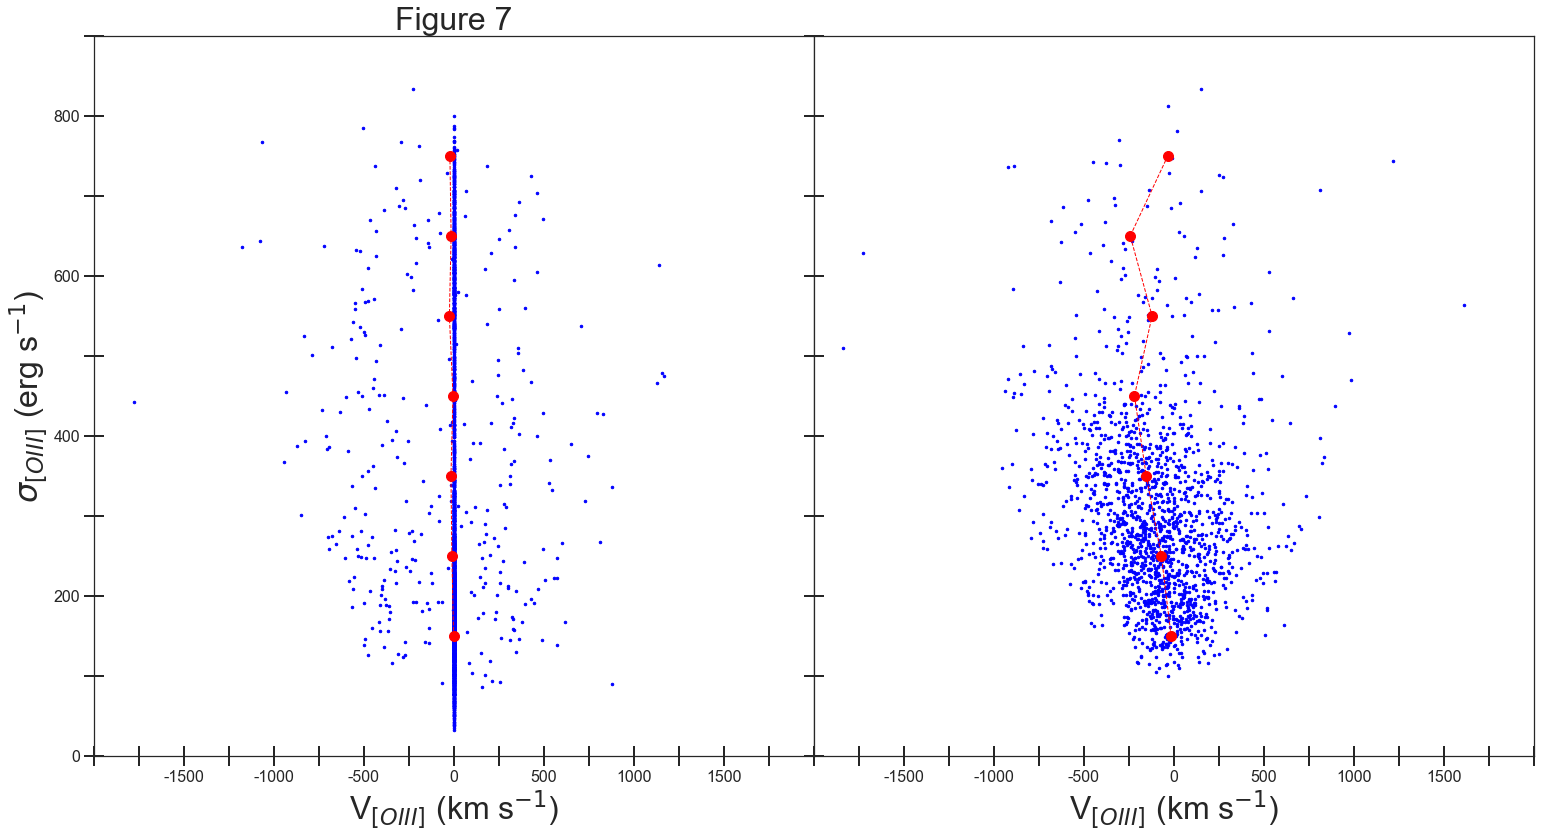

In [136]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize=(10,10))

ax1 = fig.add_axes([0, 0, 1, 1], ylim = (0, 900), xlim = (-2000, 2000))
ax2 = fig.add_axes([1, 0, 1, 1], ylim = (0, 900), xlim = (-2000, 2000))

ax1.plot(sg_vel_shift, sg_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1.errorbar(mean_sg_velshift_fig7, OIII_sigma_yaxis_fig7, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)


ax1.set_xticks(np.arange(-2000, 2250, 250))
ax1.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 16)
ax1.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax1.set_yticks(np.arange(0,1000,100))
ax1.set_yticklabels([0, '', 200, '', 400, '', 600, '', 800, ''], fontsize = 16)

##############################################################

ax2.plot(dg_vel_shift, dg_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2.errorbar(mean_dg_velshift_fig7, OIII_sigma_yaxis_fig7, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax2.set_yticks(np.arange(0,1000,100))
ax2.set_yticklabels([], fontsize = 16)
ax2.set_xticks(np.arange(-2000, 2250, 250))
ax2.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 16)
ax2.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

ax1.set_ylabel(r'$\sigma$$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)

ax1.tick_params(length = 20, width = 2, direction = 'inout')
ax2.tick_params(length = 20, width = 2, direction = 'inout')

ax1.set_title('Figure 7', fontsize = 32)

plt.show()

In [88]:
##############################################################
############################################################## END FIG 7
##############################################################

In [89]:
############################################################## 
############################################################## START FIG 8
############################################################## 

In [90]:
OIII_sigma_fig8 = np.concatenate((OIII_sigma_array_zbin1_good, OIII_sigma_array_zbin2_good,
                                  OIII_sigma_array_zbin3_good, OIII_sigma_array_zbin4_good))

log_sigma_ratio_fig8 = np.concatenate((zbin1_log_sigma_ratio, zbin2_log_sigma_ratio,
                                       zbin3_log_sigma_ratio, zbin4_log_sigma_ratio))

vel_shift_fig8 = vel_shift

In [91]:
lumbin1_OIII_sigma = OIII_sigma_fig8[select_lumbin1]
lumbin2_OIII_sigma = OIII_sigma_fig8[select_lumbin2]
lumbin3_OIII_sigma = OIII_sigma_fig8[select_lumbin3]
lumbin4_OIII_sigma = OIII_sigma_fig8[select_lumbin4]
lumbin5_OIII_sigma = OIII_sigma_fig8[select_lumbin5]

lumbin1_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin1]
lumbin2_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin2]
lumbin3_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin3]
lumbin4_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin4]
lumbin5_log_sigma_ratio = log_sigma_ratio_fig8[select_lumbin5]

lumbin1_vel_shift = vel_shift_fig8[select_lumbin1]
lumbin2_vel_shift = vel_shift_fig8[select_lumbin2]
lumbin3_vel_shift = vel_shift_fig8[select_lumbin3]
lumbin4_vel_shift = vel_shift_fig8[select_lumbin4]
lumbin5_vel_shift = vel_shift_fig8[select_lumbin5]

In [92]:
select_lumbin1_sigmabin1 = (lumbin1_OIII_sigma < 200)
select_lumbin1_sigmabin2 = (lumbin1_OIII_sigma < 300) & (lumbin1_OIII_sigma > 200)
select_lumbin1_sigmabin3 = (lumbin1_OIII_sigma < 400) & (lumbin1_OIII_sigma > 300)
select_lumbin1_sigmabin4 = (lumbin1_OIII_sigma < 500) & (lumbin1_OIII_sigma > 400)
select_lumbin1_sigmabin5 = (lumbin1_OIII_sigma < 600) & (lumbin1_OIII_sigma > 500)
select_lumbin1_sigmabin6 = (lumbin1_OIII_sigma < 700) & (lumbin1_OIII_sigma > 600)
select_lumbin1_sigmabin7 = (lumbin1_OIII_sigma > 700)

select_lumbin2_sigmabin1 = (lumbin2_OIII_sigma < 200)
select_lumbin2_sigmabin2 = (lumbin2_OIII_sigma < 300) & (lumbin2_OIII_sigma > 200)
select_lumbin2_sigmabin3 = (lumbin2_OIII_sigma < 400) & (lumbin2_OIII_sigma > 300)
select_lumbin2_sigmabin4 = (lumbin2_OIII_sigma < 500) & (lumbin2_OIII_sigma > 400)
select_lumbin2_sigmabin5 = (lumbin2_OIII_sigma < 600) & (lumbin2_OIII_sigma > 500)
select_lumbin2_sigmabin6 = (lumbin2_OIII_sigma < 700) & (lumbin2_OIII_sigma > 600)
select_lumbin2_sigmabin7 = (lumbin2_OIII_sigma > 700)

select_lumbin3_sigmabin1 = (lumbin3_OIII_sigma < 200)
select_lumbin3_sigmabin2 = (lumbin3_OIII_sigma < 300) & (lumbin3_OIII_sigma > 200)
select_lumbin3_sigmabin3 = (lumbin3_OIII_sigma < 400) & (lumbin3_OIII_sigma > 300)
select_lumbin3_sigmabin4 = (lumbin3_OIII_sigma < 500) & (lumbin3_OIII_sigma > 400)
select_lumbin3_sigmabin5 = (lumbin3_OIII_sigma < 600) & (lumbin3_OIII_sigma > 500)
select_lumbin3_sigmabin6 = (lumbin3_OIII_sigma < 700) & (lumbin3_OIII_sigma > 600)
select_lumbin3_sigmabin7 = (lumbin3_OIII_sigma > 700)

select_lumbin4_sigmabin1 = (lumbin4_OIII_sigma < 200)
select_lumbin4_sigmabin2 = (lumbin4_OIII_sigma < 300) & (lumbin4_OIII_sigma > 200)
select_lumbin4_sigmabin3 = (lumbin4_OIII_sigma < 400) & (lumbin4_OIII_sigma > 300)
select_lumbin4_sigmabin4 = (lumbin4_OIII_sigma < 500) & (lumbin4_OIII_sigma > 400)
select_lumbin4_sigmabin5 = (lumbin4_OIII_sigma < 600) & (lumbin4_OIII_sigma > 500)
select_lumbin4_sigmabin6 = (lumbin4_OIII_sigma < 700) & (lumbin4_OIII_sigma > 600)
select_lumbin4_sigmabin7 = (lumbin4_OIII_sigma > 700)

select_lumbin5_sigmabin1 = (lumbin5_OIII_sigma < 200)
select_lumbin5_sigmabin2 = (lumbin5_OIII_sigma < 300) & (lumbin5_OIII_sigma > 200)
select_lumbin5_sigmabin3 = (lumbin5_OIII_sigma < 400) & (lumbin5_OIII_sigma > 300)
select_lumbin5_sigmabin4 = (lumbin5_OIII_sigma < 500) & (lumbin5_OIII_sigma > 400)
select_lumbin5_sigmabin5 = (lumbin5_OIII_sigma < 600) & (lumbin5_OIII_sigma > 500)
select_lumbin5_sigmabin6 = (lumbin5_OIII_sigma > 600)

In [93]:
lumbin1_sigmabin1_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin1]
lumbin1_sigmabin2_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin2]
lumbin1_sigmabin3_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin3]
lumbin1_sigmabin4_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin4]
lumbin1_sigmabin5_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin5]
lumbin1_sigmabin6_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin6]
lumbin1_sigmabin7_vel_shift = lumbin1_vel_shift[select_lumbin1_sigmabin7]

lumbin2_sigmabin1_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin1]
lumbin2_sigmabin2_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin2]
lumbin2_sigmabin3_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin3]
lumbin2_sigmabin4_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin4]
lumbin2_sigmabin5_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin5]
lumbin2_sigmabin6_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin6]
lumbin2_sigmabin7_vel_shift = lumbin2_vel_shift[select_lumbin2_sigmabin7]

lumbin3_sigmabin1_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin1]
lumbin3_sigmabin2_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin2]
lumbin3_sigmabin3_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin3]
lumbin3_sigmabin4_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin4]
lumbin3_sigmabin5_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin5]
lumbin3_sigmabin6_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin6]
lumbin3_sigmabin7_vel_shift = lumbin3_vel_shift[select_lumbin3_sigmabin7]

lumbin4_sigmabin1_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin1]
lumbin4_sigmabin2_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin2]
lumbin4_sigmabin3_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin3]
lumbin4_sigmabin4_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin4]
lumbin4_sigmabin5_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin5]
lumbin4_sigmabin6_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin6]
lumbin4_sigmabin7_vel_shift = lumbin4_vel_shift[select_lumbin4_sigmabin7]

lumbin5_sigmabin1_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin1]
lumbin5_sigmabin2_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin2]
lumbin5_sigmabin3_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin3]
lumbin5_sigmabin4_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin4]
lumbin5_sigmabin5_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin5]
lumbin5_sigmabin6_vel_shift = lumbin5_vel_shift[select_lumbin5_sigmabin6]

fig8a_OIII_sigma_yaxis = np.array([150, 250, 350, 450, 550, 650, 750])
fig8a_OIII_sigma_yaxis_1 = np.array([150, 250, 350, 450, 550, 650])

##############################################################

lumbin1_mean_vel_shifta = np.array([np.mean(lumbin1_sigmabin1_vel_shift), np.mean(lumbin1_sigmabin2_vel_shift),
                                   np.mean(lumbin1_sigmabin3_vel_shift), np.mean(lumbin1_sigmabin4_vel_shift),
                                   np.mean(lumbin1_sigmabin5_vel_shift), np.mean(lumbin1_sigmabin5_vel_shift),
                                   np.mean(lumbin1_sigmabin7_vel_shift)])

lumbin1_std_vel_shifta = np.array([np.std(lumbin1_sigmabin1_vel_shift), np.std(lumbin1_sigmabin2_vel_shift),
                                  np.std(lumbin1_sigmabin3_vel_shift), np.std(lumbin1_sigmabin4_vel_shift),
                                  np.std(lumbin1_sigmabin5_vel_shift), np.std(lumbin1_sigmabin5_vel_shift),
                                  np.std(lumbin1_sigmabin7_vel_shift)])

##############################################################

lumbin2_mean_vel_shifta = np.array([np.mean(lumbin2_sigmabin1_vel_shift), np.mean(lumbin2_sigmabin2_vel_shift),
                                   np.mean(lumbin2_sigmabin3_vel_shift), np.mean(lumbin2_sigmabin4_vel_shift),
                                   np.mean(lumbin2_sigmabin5_vel_shift), np.mean(lumbin2_sigmabin5_vel_shift),
                                   np.mean(lumbin2_sigmabin7_vel_shift)])

lumbin2_std_vel_shifta = np.array([np.std(lumbin2_sigmabin1_vel_shift), np.std(lumbin2_sigmabin2_vel_shift),
                                  np.std(lumbin2_sigmabin3_vel_shift), np.std(lumbin2_sigmabin4_vel_shift),
                                  np.std(lumbin2_sigmabin5_vel_shift), np.std(lumbin2_sigmabin5_vel_shift),
                                  np.std(lumbin2_sigmabin7_vel_shift)])

##############################################################

lumbin3_mean_vel_shifta = np.array([np.mean(lumbin3_sigmabin1_vel_shift), np.mean(lumbin3_sigmabin2_vel_shift),
                                   np.mean(lumbin3_sigmabin3_vel_shift), np.mean(lumbin3_sigmabin4_vel_shift),
                                   np.mean(lumbin3_sigmabin5_vel_shift), np.mean(lumbin3_sigmabin5_vel_shift),
                                   np.mean(lumbin3_sigmabin7_vel_shift)])

lumbin3_std_vel_shifta = np.array([np.std(lumbin3_sigmabin1_vel_shift), np.std(lumbin3_sigmabin2_vel_shift),
                                  np.std(lumbin3_sigmabin3_vel_shift), np.std(lumbin3_sigmabin4_vel_shift),
                                  np.std(lumbin3_sigmabin5_vel_shift), np.std(lumbin3_sigmabin5_vel_shift),
                                  np.std(lumbin3_sigmabin7_vel_shift)])

##############################################################

lumbin4_mean_vel_shifta = np.array([np.mean(lumbin4_sigmabin1_vel_shift), np.mean(lumbin4_sigmabin2_vel_shift),
                                   np.mean(lumbin4_sigmabin3_vel_shift), np.mean(lumbin4_sigmabin4_vel_shift),
                                   np.mean(lumbin4_sigmabin5_vel_shift), np.mean(lumbin4_sigmabin5_vel_shift),
                                   np.mean(lumbin4_sigmabin7_vel_shift)])

lumbin4_std_vel_shifta = np.array([np.std(lumbin4_sigmabin1_vel_shift), np.std(lumbin4_sigmabin2_vel_shift),
                                  np.std(lumbin4_sigmabin3_vel_shift), np.std(lumbin4_sigmabin4_vel_shift),
                                  np.std(lumbin4_sigmabin5_vel_shift), np.std(lumbin4_sigmabin5_vel_shift),
                                  np.std(lumbin4_sigmabin7_vel_shift)])

##############################################################

lumbin5_mean_vel_shifta = np.array([np.mean(lumbin5_sigmabin1_vel_shift), np.mean(lumbin5_sigmabin2_vel_shift),
                                   np.mean(lumbin5_sigmabin3_vel_shift), np.mean(lumbin5_sigmabin4_vel_shift),
                                   np.mean(lumbin5_sigmabin5_vel_shift), np.mean(lumbin5_sigmabin5_vel_shift)])

lumbin5_std_vel_shifta = np.array([np.std(lumbin5_sigmabin1_vel_shift), np.std(lumbin5_sigmabin2_vel_shift),
                                  np.std(lumbin5_sigmabin3_vel_shift), np.std(lumbin5_sigmabin4_vel_shift),
                                  np.std(lumbin5_sigmabin5_vel_shift), np.std(lumbin5_sigmabin5_vel_shift)])

In [94]:
select_lumbin1_logsigratbin1 = (lumbin1_log_sigma_ratio < 0)
select_lumbin1_logsigratbin2 = (lumbin1_log_sigma_ratio > 0)   & (lumbin1_log_sigma_ratio < 0.5)
select_lumbin1_logsigratbin3 = (lumbin1_log_sigma_ratio > 0.5) & (lumbin1_log_sigma_ratio < 1)
select_lumbin1_logsigratbin4 = (lumbin1_log_sigma_ratio > 1)

select_lumbin2_logsigratbin1 = (lumbin2_log_sigma_ratio < -0.5)
select_lumbin2_logsigratbin3 = (lumbin2_log_sigma_ratio > -0.5) & (lumbin2_log_sigma_ratio < 0)
select_lumbin2_logsigratbin2 = (lumbin2_log_sigma_ratio > 0)    & (lumbin2_log_sigma_ratio < 0.5)
select_lumbin2_logsigratbin4 = (lumbin2_log_sigma_ratio > 0.5)  & (lumbin2_log_sigma_ratio < 1)
select_lumbin2_logsigratbin5 = (lumbin2_log_sigma_ratio > 1)    & (lumbin2_log_sigma_ratio < 1.5)
select_lumbin2_logsigratbin6 = (lumbin2_log_sigma_ratio > 1.5)

select_lumbin3_logsigratbin1 = (lumbin3_log_sigma_ratio < -0.5)
select_lumbin3_logsigratbin3 = (lumbin3_log_sigma_ratio > -0.5) & (lumbin3_log_sigma_ratio < 0)
select_lumbin3_logsigratbin2 = (lumbin3_log_sigma_ratio > 0)    & (lumbin3_log_sigma_ratio < 0.5)
select_lumbin3_logsigratbin4 = (lumbin3_log_sigma_ratio > 0.5)  & (lumbin3_log_sigma_ratio < 1)
select_lumbin3_logsigratbin5 = (lumbin3_log_sigma_ratio > 1)    & (lumbin3_log_sigma_ratio < 1.5)
select_lumbin3_logsigratbin6 = (lumbin3_log_sigma_ratio > 1.5)

select_lumbin4_logsigratbin1 = (lumbin4_log_sigma_ratio < 0)
select_lumbin4_logsigratbin2 = (lumbin4_log_sigma_ratio > 0)    & (lumbin4_log_sigma_ratio < 0.5)
select_lumbin4_logsigratbin3 = (lumbin4_log_sigma_ratio > 0.5)  & (lumbin4_log_sigma_ratio < 1)
select_lumbin4_logsigratbin4 = (lumbin4_log_sigma_ratio > 1)    & (lumbin4_log_sigma_ratio < 1.5)
select_lumbin4_logsigratbin5 = (lumbin4_log_sigma_ratio > 1.5)

select_lumbin5_logsigratbin1 = (lumbin5_log_sigma_ratio < 0)
select_lumbin5_logsigratbin2 = (lumbin5_log_sigma_ratio > 0)    & (lumbin5_log_sigma_ratio < 0.5)
select_lumbin5_logsigratbin3 = (lumbin5_log_sigma_ratio > 0.5)  & (lumbin5_log_sigma_ratio < 1)
select_lumbin5_logsigratbin4 = (lumbin5_log_sigma_ratio > 1)    & (lumbin5_log_sigma_ratio < 1.5)
select_lumbin5_logsigratbin5 = (lumbin5_log_sigma_ratio > 1.5)

In [95]:
lumbin1_logsigratbin1_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin1]
lumbin1_logsigratbin2_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin2]
lumbin1_logsigratbin3_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin3]
lumbin1_logsigratbin4_vel_shift = lumbin1_vel_shift[select_lumbin1_logsigratbin4]

lumbin2_logsigratbin1_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin1]
lumbin2_logsigratbin2_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin2]
lumbin2_logsigratbin3_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin3]
lumbin2_logsigratbin4_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin4]
lumbin2_logsigratbin5_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin5]
lumbin2_logsigratbin6_vel_shift = lumbin2_vel_shift[select_lumbin2_logsigratbin6]

lumbin3_logsigratbin1_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin1]
lumbin3_logsigratbin2_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin2]
lumbin3_logsigratbin3_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin3]
lumbin3_logsigratbin4_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin4]
lumbin3_logsigratbin5_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin5]
lumbin3_logsigratbin6_vel_shift = lumbin3_vel_shift[select_lumbin3_logsigratbin6]

lumbin4_logsigratbin1_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin1]
lumbin4_logsigratbin2_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin2]
lumbin4_logsigratbin3_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin3]
lumbin4_logsigratbin4_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin4]
lumbin4_logsigratbin5_vel_shift = lumbin4_vel_shift[select_lumbin4_logsigratbin5]

lumbin5_logsigratbin1_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin1]
lumbin5_logsigratbin2_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin2]
lumbin5_logsigratbin3_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin3]
lumbin5_logsigratbin4_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin4]
lumbin5_logsigratbin5_vel_shift = lumbin5_vel_shift[select_lumbin5_logsigratbin5]

fig8b_OIII_sigma_yaxis = np.array([-0.25, 0.25, 0.75, 1.25])
fig8b_OIII_sigma_yaxis_1 = np.array([-0.75, -0.25, 0.25, 0.75, 1.25, 1.75])
fig8b_OIII_sigma_yaxis_2 = np.array([-0.25, 0.25, 0.75, 1.25, 1.75])

##############################################################

lumbin1_mean_vel_shiftb = np.array([np.mean(lumbin1_logsigratbin1_vel_shift), np.mean(lumbin1_logsigratbin2_vel_shift),
                                   np.mean(lumbin1_logsigratbin3_vel_shift), np.mean(lumbin1_logsigratbin4_vel_shift)])

lumbin1_std_vel_shiftb = np.array([np.std(lumbin1_logsigratbin1_vel_shift), np.std(lumbin1_logsigratbin2_vel_shift),
                                  np.std(lumbin1_logsigratbin3_vel_shift), np.std(lumbin1_logsigratbin4_vel_shift)])

##############################################################

lumbin2_mean_vel_shiftb = np.array([np.mean(lumbin2_logsigratbin1_vel_shift), np.mean(lumbin2_logsigratbin2_vel_shift),
                                   np.mean(lumbin2_logsigratbin3_vel_shift), np.mean(lumbin2_logsigratbin4_vel_shift),
                                   np.mean(lumbin2_logsigratbin5_vel_shift), np.mean(lumbin2_logsigratbin6_vel_shift)])

lumbin2_std_vel_shiftb = np.array([np.std(lumbin2_logsigratbin1_vel_shift), np.std(lumbin2_logsigratbin2_vel_shift),
                                  np.std(lumbin2_logsigratbin3_vel_shift), np.std(lumbin2_logsigratbin4_vel_shift),
                                  np.std(lumbin2_logsigratbin5_vel_shift), np.std(lumbin2_logsigratbin6_vel_shift)])

##############################################################

lumbin3_mean_vel_shiftb = np.array([np.mean(lumbin3_logsigratbin1_vel_shift), np.mean(lumbin3_logsigratbin2_vel_shift),
                                   np.mean(lumbin3_logsigratbin3_vel_shift), np.mean(lumbin3_logsigratbin4_vel_shift),
                                   np.mean(lumbin3_logsigratbin5_vel_shift), np.mean(lumbin3_logsigratbin6_vel_shift)])

lumbin3_std_vel_shiftb = np.array([np.std(lumbin3_logsigratbin1_vel_shift), np.std(lumbin3_logsigratbin2_vel_shift),
                                  np.std(lumbin3_logsigratbin3_vel_shift), np.std(lumbin3_logsigratbin4_vel_shift),
                                  np.std(lumbin3_logsigratbin5_vel_shift), np.std(lumbin3_logsigratbin6_vel_shift)])

##############################################################

lumbin4_mean_vel_shiftb = np.array([np.mean(lumbin4_logsigratbin1_vel_shift), np.mean(lumbin4_logsigratbin2_vel_shift),
                                   np.mean(lumbin4_logsigratbin3_vel_shift), np.mean(lumbin4_logsigratbin4_vel_shift),
                                   np.mean(lumbin4_logsigratbin5_vel_shift)])

lumbin4_std_vel_shiftb = np.array([np.std(lumbin4_logsigratbin1_vel_shift), np.std(lumbin4_logsigratbin2_vel_shift),
                                  np.std(lumbin4_logsigratbin3_vel_shift), np.std(lumbin4_logsigratbin4_vel_shift),
                                  np.std(lumbin4_logsigratbin5_vel_shift)])

##############################################################

lumbin5_mean_vel_shiftb = np.array([np.mean(lumbin5_logsigratbin1_vel_shift), np.mean(lumbin5_logsigratbin2_vel_shift),
                                   np.mean(lumbin5_logsigratbin3_vel_shift), np.mean(lumbin5_logsigratbin4_vel_shift),
                                   np.mean(lumbin5_logsigratbin5_vel_shift)])

lumbin5_std_vel_shiftb = np.array([np.std(lumbin5_logsigratbin1_vel_shift), np.std(lumbin5_logsigratbin2_vel_shift),
                                  np.std(lumbin5_logsigratbin3_vel_shift), np.std(lumbin5_logsigratbin4_vel_shift),
                                  np.std(lumbin5_logsigratbin5_vel_shift)])

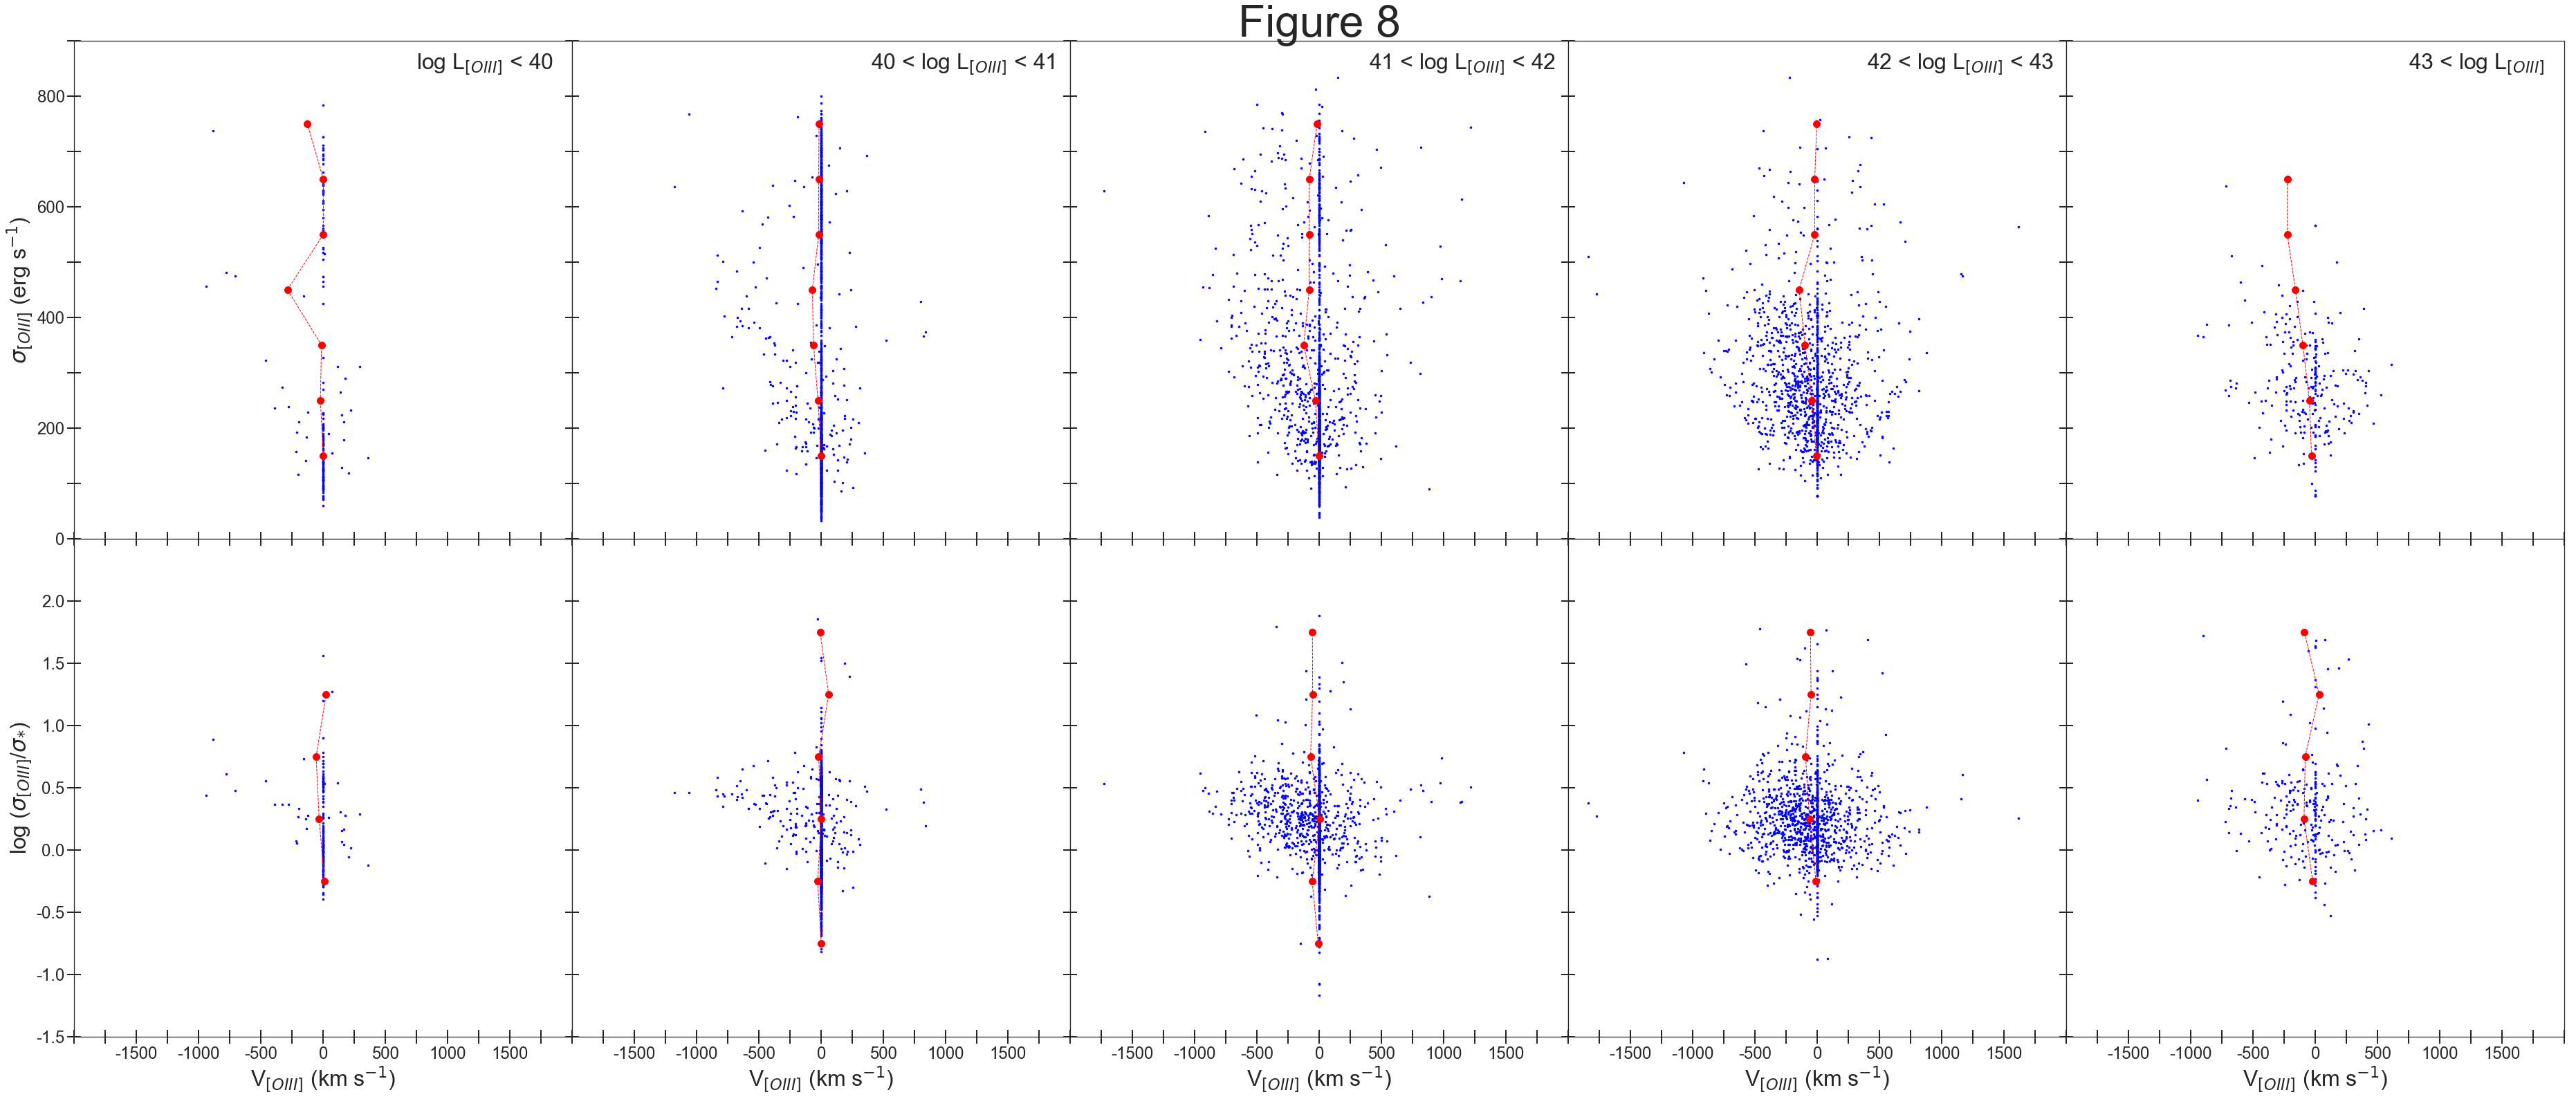

In [133]:
plt.style.use('seaborn-ticks')
fig = plt.figure(figsize = (10,10))

ax1b = fig.add_axes([0, -1, 1, 1], ylim = (-1.5, 2.5), xlim = (-2000, 2000))
ax2b = fig.add_axes([1, -1, 1, 1], ylim = (-1.5, 2.5), xlim = (-2000, 2000))
ax3b = fig.add_axes([2, -1, 1, 1], ylim = (-1.5, 2.5), xlim = (-2000, 2000))
ax4b = fig.add_axes([3, -1, 1, 1], ylim = (-1.5, 2.5), xlim = (-2000, 2000))
ax5b = fig.add_axes([4, -1, 1, 1], ylim = (-1.5, 2.5), xlim = (-2000, 2000))

ax1a = fig.add_axes([0, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax2a = fig.add_axes([1, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax3a = fig.add_axes([2, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax4a = fig.add_axes([3, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))
ax5a = fig.add_axes([4, 0, 1, 1], ylim = (0,900), xlim = (-2000, 2000))

ax1a.plot(lumbin1_vel_shift, lumbin1_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1a.errorbar(lumbin1_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax2a.plot(lumbin2_vel_shift, lumbin2_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2a.errorbar(lumbin2_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax3a.plot(lumbin3_vel_shift, lumbin3_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax3a.errorbar(lumbin3_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax4a.plot(lumbin4_vel_shift, lumbin4_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax4a.errorbar(lumbin4_mean_vel_shifta, fig8a_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax5a.plot(lumbin5_vel_shift, lumbin5_OIII_sigma, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax5a.errorbar(lumbin5_mean_vel_shifta, fig8a_OIII_sigma_yaxis_1, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

##############################################################

ax1b.plot(lumbin1_vel_shift, lumbin1_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax1b.errorbar(lumbin1_mean_vel_shiftb, fig8b_OIII_sigma_yaxis, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax2b.plot(lumbin2_vel_shift, lumbin2_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax2b.errorbar(lumbin2_mean_vel_shiftb, fig8b_OIII_sigma_yaxis_1, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax3b.plot(lumbin3_vel_shift, lumbin3_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax3b.errorbar(lumbin3_mean_vel_shiftb, fig8b_OIII_sigma_yaxis_1, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax4b.plot(lumbin4_vel_shift, lumbin4_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax4b.errorbar(lumbin4_mean_vel_shiftb, fig8b_OIII_sigma_yaxis_2, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax5b.plot(lumbin5_vel_shift, lumbin5_log_sigma_ratio, color = 'blue',   linestyle = '', marker = '.', ms = 5)
ax5b.errorbar(lumbin5_mean_vel_shiftb, fig8b_OIII_sigma_yaxis_2, color = 'red', linewidth = 1, linestyle = '--', marker = 'o', ms = 10, capsize = 5)

ax1a.set_yticks(np.arange(0, 1000, 100))
ax2a.set_yticks(np.arange(0, 1000, 100))
ax3a.set_yticks(np.arange(0, 1000, 100))
ax4a.set_yticks(np.arange(0, 1000, 100))
ax5a.set_yticks(np.arange(0, 1000, 100))

ax1a.set_yticklabels([0, '', 200, '', 400, '', 600, '', 800, ''], fontsize = 24)
ax2a.set_yticklabels([])
ax3a.set_yticklabels([])
ax4a.set_yticklabels([])
ax5a.set_yticklabels([])

ax1a.set_xticks(np.arange(-2000, 2250, 250))
ax2a.set_xticks(np.arange(-2000, 2250, 250))
ax3a.set_xticks(np.arange(-2000, 2250, 250))
ax4a.set_xticks(np.arange(-2000, 2250, 250))
ax5a.set_xticks(np.arange(-2000, 2250, 250))

ax1a.set_xticklabels([])
ax2a.set_xticklabels([])
ax3a.set_xticklabels([])
ax4a.set_xticklabels([])
ax5a.set_xticklabels([])

ax1b.set_yticks(np.arange(-1.5, 3, 0.5))
ax2b.set_yticks(np.arange(-1.5, 3, 0.5))
ax3b.set_yticks(np.arange(-1.5, 3, 0.5))
ax4b.set_yticks(np.arange(-1.5, 3, 0.5))
ax5b.set_yticks(np.arange(-1.5, 3, 0.5))

ax1b.set_yticklabels([-1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0], fontsize = 24)
ax2b.set_yticklabels([])
ax3b.set_yticklabels([])
ax4b.set_yticklabels([])
ax5b.set_yticklabels([])

ax1b.set_xticks(np.arange(-2000, 2250, 250))
ax2b.set_xticks(np.arange(-2000, 2250, 250))
ax3b.set_xticks(np.arange(-2000, 2250, 250))
ax4b.set_xticks(np.arange(-2000, 2250, 250))
ax5b.set_xticks(np.arange(-2000, 2250, 250))

ax1b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 24)
ax2b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 24)
ax3b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 24)
ax4b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 24)
ax5b.set_xticklabels(['', '', -1500, '', -1000, '', -500, '', 0, '', 500, '', 1000, '', 1500], fontsize = 24)

ax1b.tick_params(length = 20, width = 2, direction = 'inout')
ax2b.tick_params(length = 20, width = 2, direction = 'inout')
ax3b.tick_params(length = 20, width = 2, direction = 'inout')
ax4b.tick_params(length = 20, width = 2, direction = 'inout')
ax5b.tick_params(length = 20, width = 2, direction = 'inout')

ax1a.tick_params(length = 20, width = 2, direction = 'inout')
ax2a.tick_params(length = 20, width = 2, direction = 'inout')
ax3a.tick_params(length = 20, width = 2, direction = 'inout')
ax4a.tick_params(length = 20, width = 2, direction = 'inout')
ax5a.tick_params(length = 20, width = 2, direction = 'inout')

ax1a.text(750, 850, r'log L$_{[OIII]}$ < 40', fontsize = 32)
ax2a.text(400, 850, r'40 < log L$_{[OIII]}$ < 41', fontsize = 32)
ax3a.text(400, 850, r'41 < log L$_{[OIII]}$ < 42', fontsize = 32)
ax4a.text(400, 850, r'42 < log L$_{[OIII]}$ < 43', fontsize = 32)
ax5a.text(750, 850, r'43 < log L$_{[OIII]}$', fontsize = 32)

ax1a.set_ylabel(r'$\sigma$$_{[OIII]}$ (erg s$^{-1}$)', fontsize = 32)
ax1b.set_ylabel(r'log ($\sigma$$_{[OIII]}$/$\sigma$$_{*}$)', fontsize = 32)

ax1b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax2b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax3b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax4b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)
ax5b.set_xlabel(r'V$_{[OIII]}$ (km s$^{-1}$)', fontsize = 32)

ax3a.set_title('Figure 8', fontsize = 64)

# fig.savefig('fig8.png')

plt.show()

In [97]:
##############################################################
############################################################## END FIG 8
##############################################################